<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, assign_wcs step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
import os
from astropy.io import fits

from jwst.assign_wcs.assign_wcs_step import AssignWcsStep

# This installs the latest version of PTT
import subprocess
#subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@1.0.2'])
# this tag needs to be in the requirements.txt file of this repo

# import NPTT
import nirspec_pipe_testing_tool as nptt

In [2]:
# Make sure that the version used is the right one

# to get the latest version from 'master' run:
# subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@master'])

latest_nptt_stable_version = '1.0.2'
nptt_version = nptt.__version__

if nptt_version != latest_nptt_stable_version:
    print("* WARNING - The code might break because the version used is not the latest stable version:")
    print("            Latest stable version is ", latest_nptt_stable_version)
    print("            Using NPTT version ", nptt_version)

* WARNING - The code might break because the version used is not the latest stable version:
            Latest stable version is  1.0.2
            Using NPTT version  1.0.3.dev0+g18d5187.d20200707


<a id="intro_ID"></a>
# Introduction

We compared Institute's pipeline product of the assign_wcs step with our benchmark files, or with the intermediary products from the ESA pipeline, which is completely independent from the Institute's. The comparison file is referred to as 'truth'. We calculated the relative difference and expected it to be equal to or less than computer precision:  relative_difference = absolute_value( (Truth - ST)/Truth )  <= 1x10^-7. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/compare_wcs_fs.py. For Multi Object Spectroscopy (MOS), the code is in the same repository but is named ```compare_wcs_mos.py```, and for Integral Field Unit (IFU) data, the test is named ```compare_wcs_ifu.py```.
The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing:
- FS - FULLFRAME, G140M, OPAQUE
- FS - ALLSLITS, G235H, F170LP 
- IFU - G395H, OPAQUE  and  PRISM, CLEAR
- MOS - G140M, F100LP 

The testing data can be located at ```/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite```

In that directory you will find a subdirectory for CV3 data for FS, MOS, and IFU, as well as other campaigns. This notebook is specifically written for CV3 data.

A benchmark test run of this notebook can be done with data located at: 
```/grp/jwst/wit4/nirspec_vault/pipe_testing_tool/PTT_FS_benchmark_run```

In that directory you will find:
- NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits (which is what we call the raw_data_file)
- gain_scale_NRS1.fits (which is the final output of cal_detector1 and the input file for your test)
- results_491 (directory that contains results of my tests, in case you want to compare your results)
- PTT_config.cfg  (a sample of a configuration file for PTT, in case you want to compare with the one you create in the test)

If you want to Download data, the only file you need is gain_scale_NRS1.fits, since this is the input file for the test.


[Top of Page](#title_ID)

Set the following variables to the file you are interested in testing:

- output_directory = path where you want intermediary files and plots to be saved in

- input_file = this is the count rate file, e.g. jwtest1_NRS1_rate.fits

- mode_used = supported modes are: FS, MOS, IFU, BOTS, MOS_sim, dark, image, confirm, taconfirm, wata, msata, focus, mimf

- raw_data_root_file = CV3 raw data file


<a id="pipeline_ID"></a>
# Run the JWST pipeline and assign_wcs validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the assign_wcs step, use the command:

$ strun jwst.assign_wcs.AssignWcsStep jwtest_rate.fits

NIRSpec TA data will be run through the cal_detector1 and the imaging2 pipelines. The imaging pipeline can be run with the following fommand:

$ strun jwst.pipeline.Image2Pipeline jwtest_rate.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
 
$\gt$ AssignWcsStep.call(jwtest_rate.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests.

To run PTT you first need to create and edit the file that controls the tool. This configuration file tells PTT which data to test, the mode, and where to put results and plots, among other variables that can be modified from the default values (e.g. paths for the flat field reference files, acceptance threshold values for differences between pipeline product and benchmark files, modify a benchmark file, etc).

[Top of Page](#title_ID)

-> For each mode, the following variables will need to be set:

- output_directory = path where you want intermediary files and plots to be saved in

- input_file = this is the count rate file, e.g. jwtest1_NRS1_rate.fits

- mode_used = supported modes are: FS, MOS, IFU, BOTS, MOS_sim, dark, image, confirm, taconfirm, wata, msata, focus, mimf

- raw_data_root_file = CV3 raw data file


<a id="FULLFRAME"></a>
# FS FULL-FRAME test

In [3]:
## Set the variables for Fixed Slit (FS) data
data_directory = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/'
input_file = os.path.join(data_directory, 'gain_scale_NRS1.fits')
mode_used = 'FS'
run_calwebb_spec2 = 'assign_wcs'
save_figs = False
show_figs = True
threshold_diff = 1e-7

In [4]:
# define benchmark (or 'truth') file
compare_assign_wcs_and_extract_2d_with_esa = True

# ESA intermediary products
raw_data_root_file = 'NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits'
esa_files_path = "/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/"
esa_files_full_path = "".join([esa_files_path, mode_used, "_CV3_cutouts/ESA_Int_products"])

# pipeline intermediary products
truth_file = os.path.join(data_directory, 'gain_scale_NRS1_assign_wcs_truth.fits')

if not compare_assign_wcs_and_extract_2d_with_esa:
    esa_files_path, raw_data_root_file = None, None
else:
    truth_file = None

In [5]:
# Run the pipeline step
step_output_file = input_file.replace(".fits", "_assign_wcs.fits")
pipe_result = AssignWcsStep.call(input_file)
#pipe_result.save(step_output_file)   # this is to save the pipeline output to a file

2020-07-09 16:04:46,368 - stpipe - WARNING - /Users/pena/anaconda3/envs/jwst162/lib/python3.7/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating meta.wcsinfo.spectral_order the following error occurred:
1.0 is not of type 'integer'

Failed validating 'type' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'fits_hdu': 'SCI',
     'fits_keyword': 'SPORDER',
     'title': 'Spectral order number',
     'type': 'integer'}

On instance:
    1.0
  warnings.warn(errmsg, ValidationWarning)

2020-07-09 16:04:46,888 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-07-09 16:04:46,889 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-07-09 16:04:46,949 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G

Comparing to ESA data
from assign_wcs file  -->     Detector: NRS1   Grating: G140M   Filter: F100LP   Lamp: LINE1
GWA_XTILT: 0.3316612243652344
GWA_YTILT: 0.1260581910610199
GWA_TTILT: 40.28447479156018

Working with slit: S200A1
 * File name matches raw file used for create_data.
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3_cutouts/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_SLIT/Trace_SLIT_A_200_1_V84600010001P0000000002101_39547_JLAB88.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3_cutouts/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_SLIT/Trace_SLIT_A_200_1_V84600010001P0000000002101_39547_JLAB88.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     43

2020-07-09 16:04:50,756 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/auxiliary_functions.py:567: RuntimeWarning: invalid value encountered in less
  in_slit = np.logical_and(edy < .5,  edy > -.5)

2020-07-09 16:04:50,757 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/auxiliary_functions.py:567: RuntimeWarning: invalid value encountered in greater
  in_slit = np.logical_and(edy < .5,  edy > -.5)




   Relative Wavelength Difference  :   mean = 8.099e-11    median = 1.007e-10    stdev = 2.464e-08
    Maximum   RelativeWavelength Difference = 5.876e-08
    Minimum   RelativeWavelength Difference = -5.862e-08
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = -1.295e-09    median = -2.429e-10    stdev = 5.088e-06
    Maximum   RelativeSlit-Y Difference = 4.375e-04
    Minimum   RelativeSlit-Y Difference = -8.318e-04
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 8%
                            ->  3xtheshold = 3%
                            ->  5xtheshold = 2%

 * Result of the test for Slit-Y Difference:  PASSED


   Relative MSA_X Dif

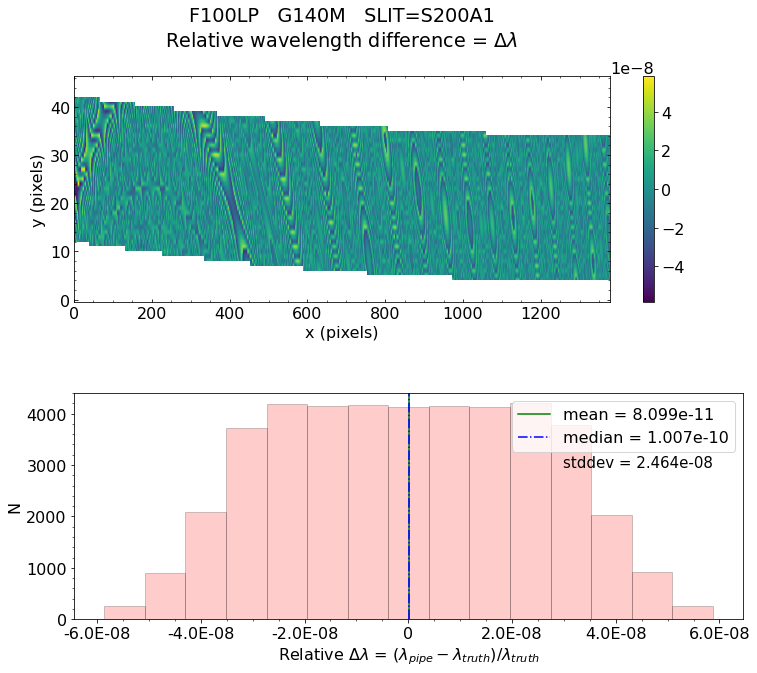

No output_directory was provided. Figures will NOT be saved.


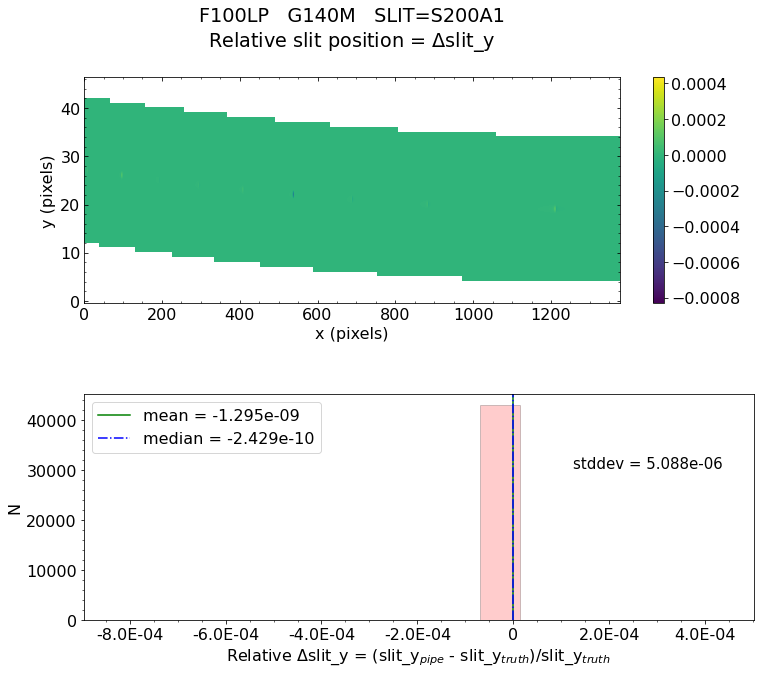

No output_directory was provided. Figures will NOT be saved.


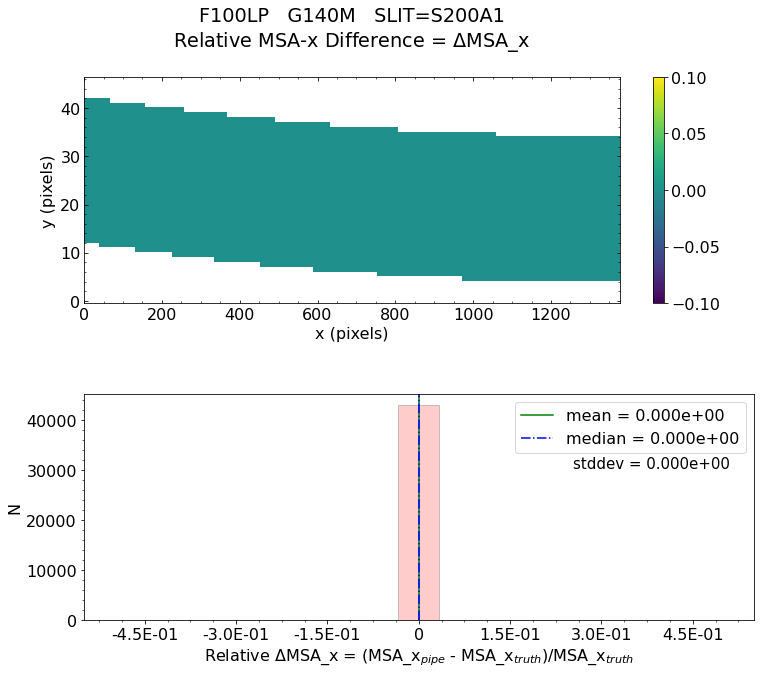

No output_directory was provided. Figures will NOT be saved.


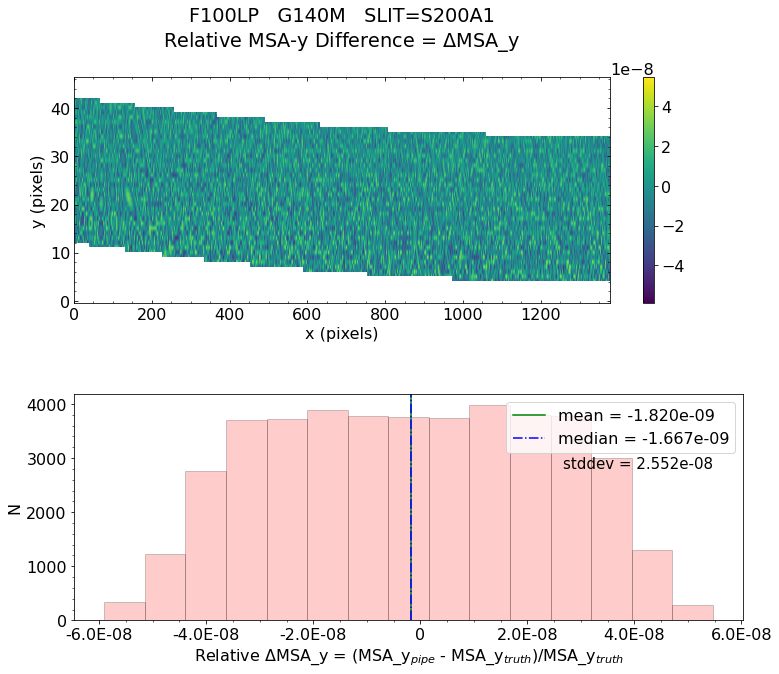


Working with slit: S200A2
 * File name matches raw file used for create_data.
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3_cutouts/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_SLIT/Trace_SLIT_A_200_2_V84600010001P0000000002101_39547_JLAB88.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3_cutouts/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_SLIT/Trace_SLIT_A_200_2_V84600010001P0000000002101_39547_JLAB88.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     432   ()      
  1  DATA1         1 ImageHDU        22   (1466, 49)   float32   
  2  QUALITY1      1 ImageHDU        24   (1466, 49)   int16 (rescales to uint16)   
  3  VAR1          1 ImageHDU        22 

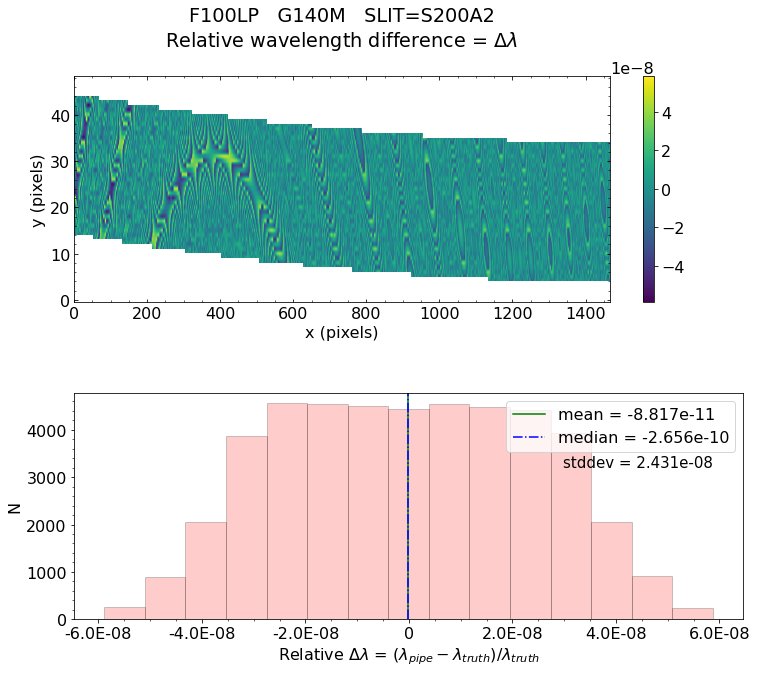

No output_directory was provided. Figures will NOT be saved.


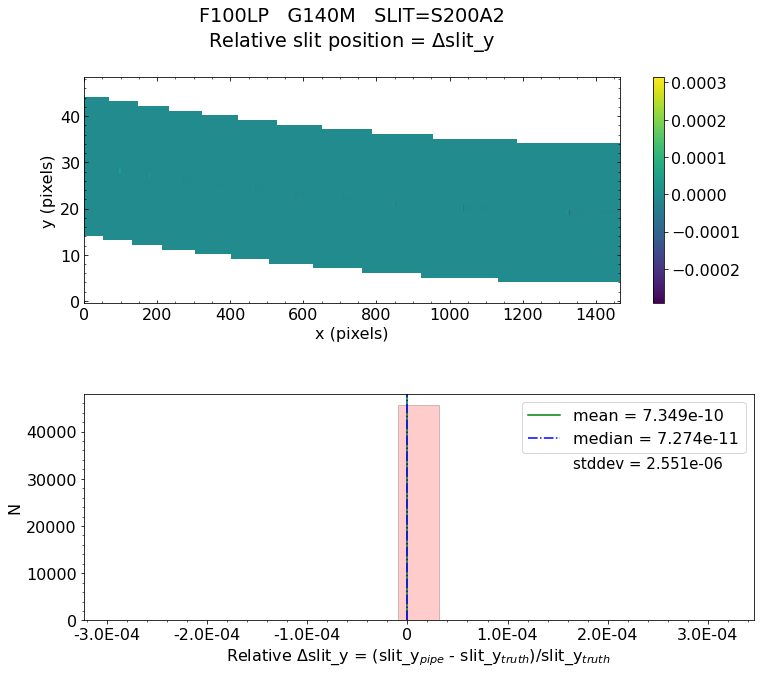

No output_directory was provided. Figures will NOT be saved.


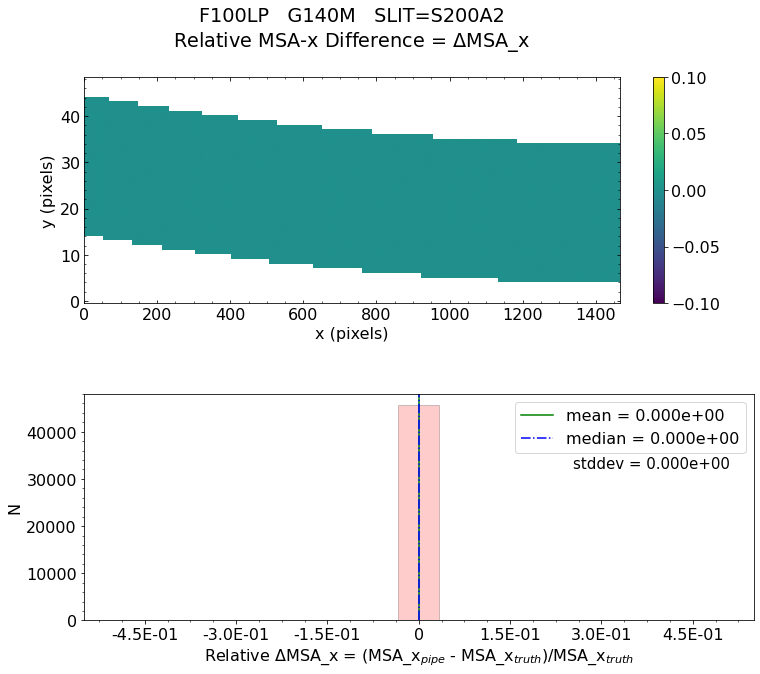

No output_directory was provided. Figures will NOT be saved.


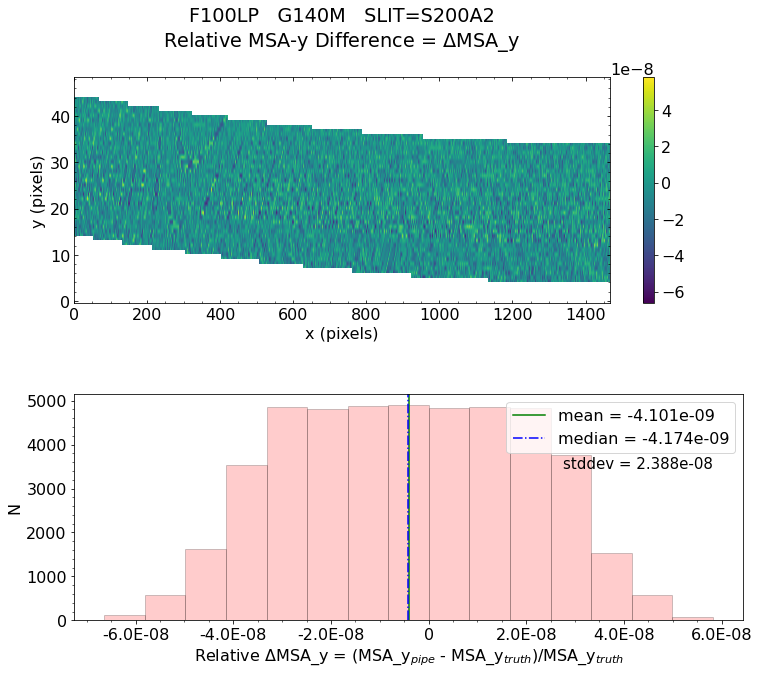


Working with slit: S400A1
 * File name matches raw file used for create_data.
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3_cutouts/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_SLIT/Trace_SLIT_A_400_V84600010001P0000000002101_39547_JLAB88.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3_cutouts/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_SLIT/Trace_SLIT_A_400_V84600010001P0000000002101_39547_JLAB88.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     432   ()      
  1  DATA1         1 ImageHDU        22   (1446, 53)   float32   
  2  QUALITY1      1 ImageHDU        24   (1446, 53)   int16 (rescales to uint16)   
  3  VAR1          1 ImageHDU        22   (1

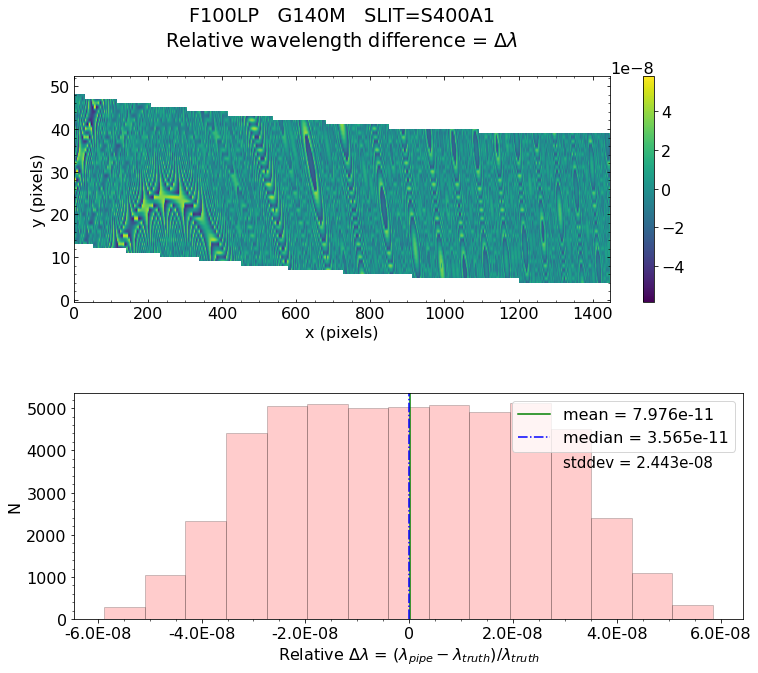

No output_directory was provided. Figures will NOT be saved.


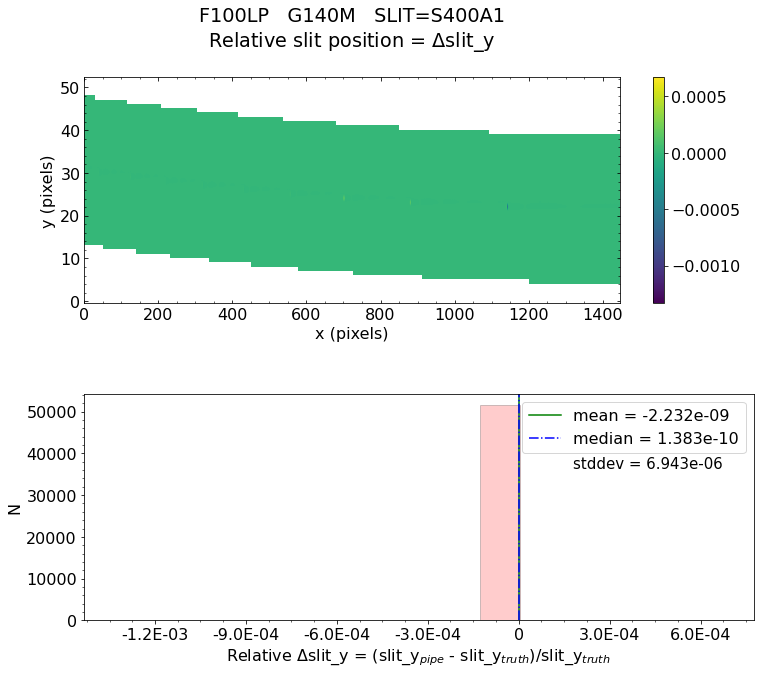

No output_directory was provided. Figures will NOT be saved.


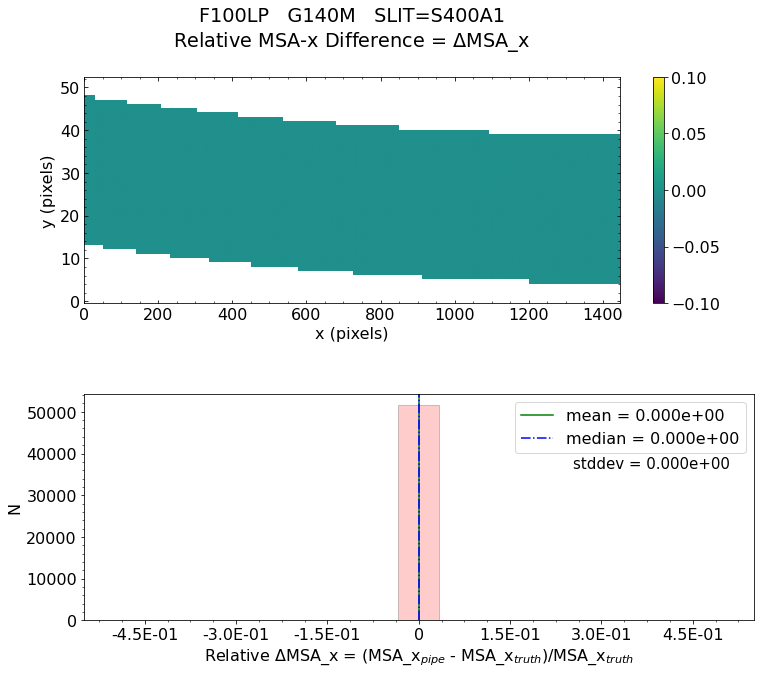

No output_directory was provided. Figures will NOT be saved.


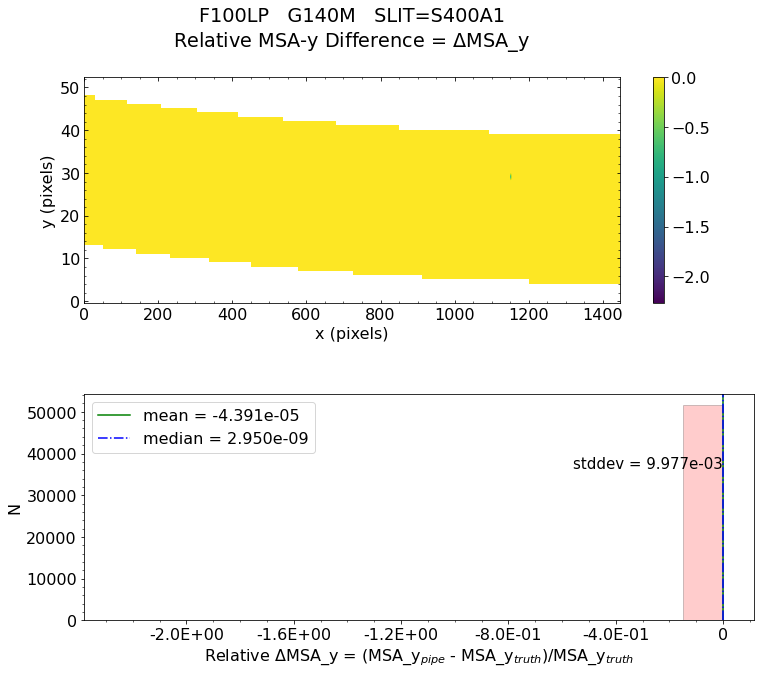


Working with slit: S1600A1
 * File name matches raw file used for create_data.
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3_cutouts/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_SLIT/Trace_SLIT_A_1600_V84600010001P0000000002101_39547_JLAB88.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3_cutouts/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_SLIT/Trace_SLIT_A_1600_V84600010001P0000000002101_39547_JLAB88.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     432   ()      
  1  DATA1         1 ImageHDU        22   (1422, 30)   float32   
  2  QUALITY1      1 ImageHDU        24   (1422, 30)   int16 (rescales to uint16)   
  3  VAR1          1 ImageHDU        22  

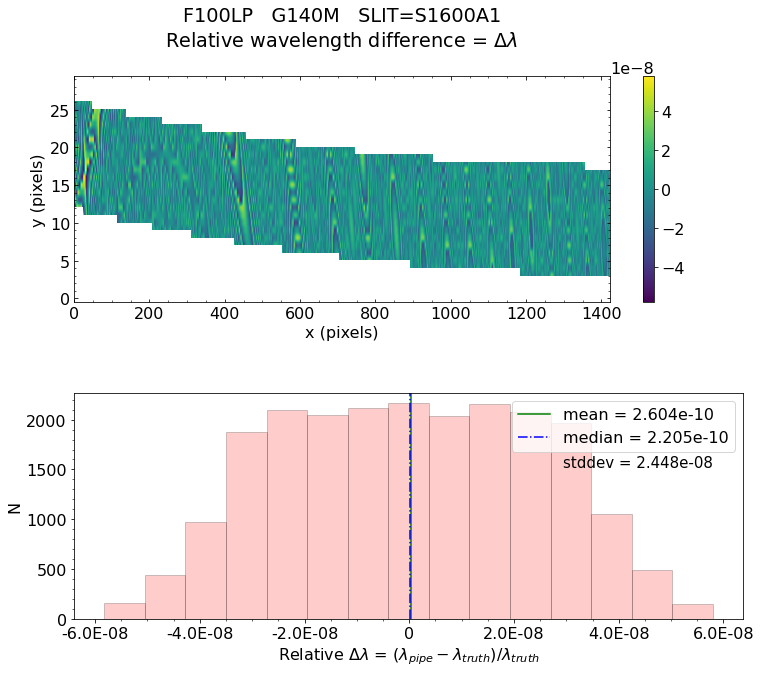

No output_directory was provided. Figures will NOT be saved.


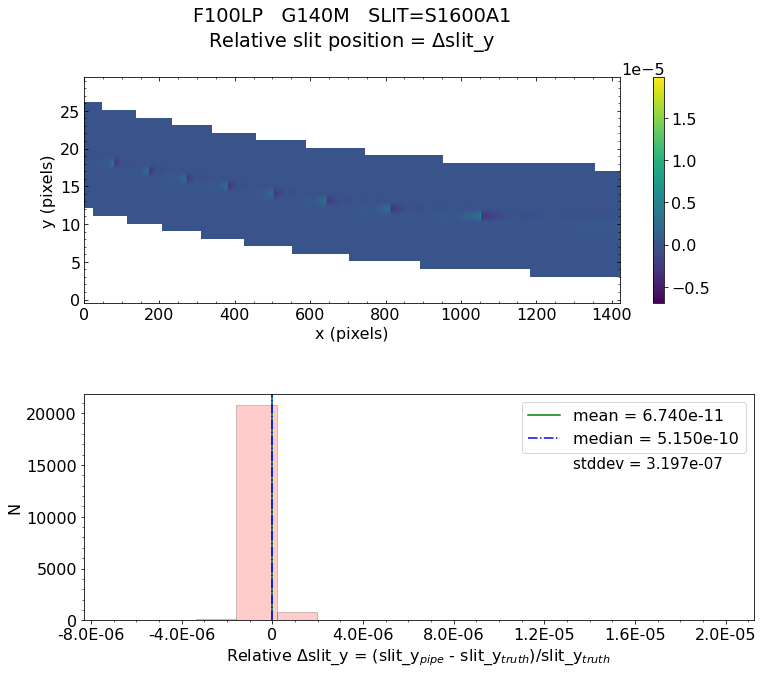

No output_directory was provided. Figures will NOT be saved.


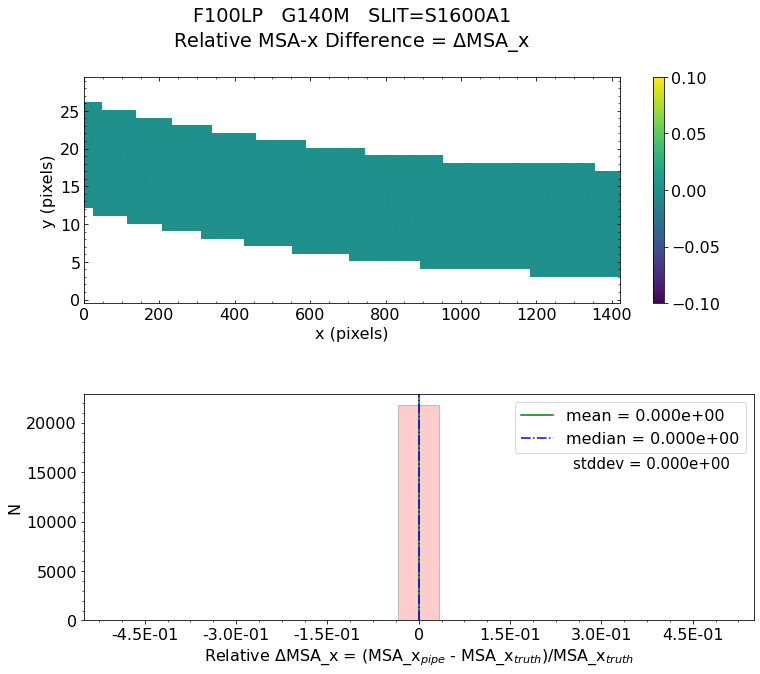

No output_directory was provided. Figures will NOT be saved.


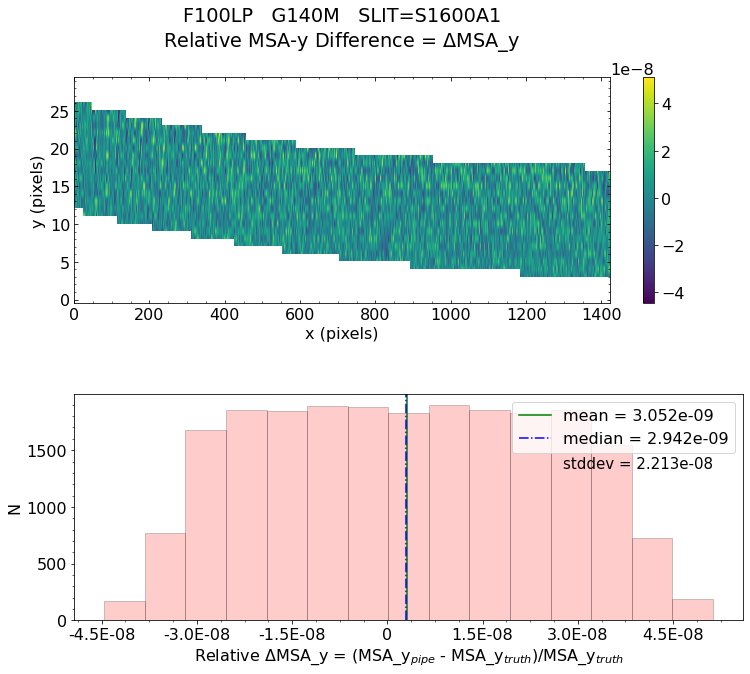


 * The test of MSA_Y Difference for slit S200A1 PASSED.

 * The test of MSA_Y Difference for slit S200A2 PASSED.

 * The test of MSA_Y Difference for slit S400A1 PASSED.

 * The test of MSA_Y Difference for slit S1600A1 PASSED.

 *** Final result for assign_wcs test will be reported as PASSED *** 



In [6]:
# Run the validation test
%matplotlib inline
result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_fs.compare_wcs(pipe_result, truth_file=truth_file, 
                                                                                 esa_files_path=esa_files_full_path, 
                                                                                 show_figs=show_figs,
                                                                                 save_figs=save_figs, 
                                                                                 threshold_diff=threshold_diff, 
                                                                                 raw_data_root_file=raw_data_root_file)

In [7]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation for FS FULL-FRAME test passed? ", result)


Did assign_wcs validation for FS FULL-FRAME test passed?  PASSED


<a id="ALLSLITS"></a>
# FS ALLSLITS test

In [8]:
# Set the variables 
data_directory = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G235M_F170LP'
input_file = os.path.join(data_directory, 'final_output_caldet1_NRS1.fits')
mode_used = 'FS'
run_calwebb_spec2 = 'assign_wcs'
msa_conf_name = '/path_to_corresponding_MSA_shutter_configuration_file/V9621500100101_short_msa.fits'
save_figs = False
show_figs = True
threshold_diff = 1e-7

In [9]:
# define benchmark (or 'truth') file
compare_assign_wcs_and_extract_2d_with_esa = True

# ESA intermediary products
raw_data_root_file = 'NRSV84600004001P0000000002102_1_491_SE_2016-01-17T15h47m57.fits'
esa_files_path = "/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/"
esa_files_full_path = "".join([esa_files_path, mode_used, "_CV3/ESA_Int_products"])

# pipeline intermediary products
truth_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_assign_wcs_truth.fits')

if not compare_assign_wcs_and_extract_2d_with_esa:
    esa_files_path, raw_data_root_file = None, None
else:
    truth_file = None

In [10]:
# Run the pipeline step
step_output_file = input_file.replace(".fits", "_assign_wcs.fits")
pipe_result = AssignWcsStep.call(input_file)
#pipe_result.save(step_output_file)   # this is to save the pipeline output to a file

2020-07-09 16:05:08,044 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-07-09 16:05:08,046 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-07-09 16:05:08,127 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_ALLSLITS/G235M_F170LP/final_output_caldet1_NRS1.fits',).
2020-07-09 16:05:08,129 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-07-09 16:05:08,325 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1395713090896606 deg
2020-07-09 16:05:08,326 - stpipe.AssignWcsStep - INFO - gwa_xti

Comparing to ESA data
from assign_wcs file  -->     Detector: NRS1   Grating: G235M   Filter: F170LP   Lamp: NO_LAMP
GWA_XTILT: 0.3213698863983154
GWA_YTILT: 0.1395713090896606
GWA_TTILT: 40.10614860855531

Working with slit: S200A1
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3/ESA_Int_products/Trace_SLIT_A_200_1_V84600004001P0000000002102_39531_JLAB88_000001.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3/ESA_Int_products/Trace_SLIT_A_200_1_V84600004001P0000000002102_39531_JLAB88_000001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     430   ()      
  1  DATA1         1 ImageHDU        22   (1332, 47)   float32   
  2  QUALITY1      1 ImageHDU        24   (1332, 47)   int16 (rescales to uint16)   
  3  VAR1          1 ImageHDU        22   (1332, 47)   float32   
  4 

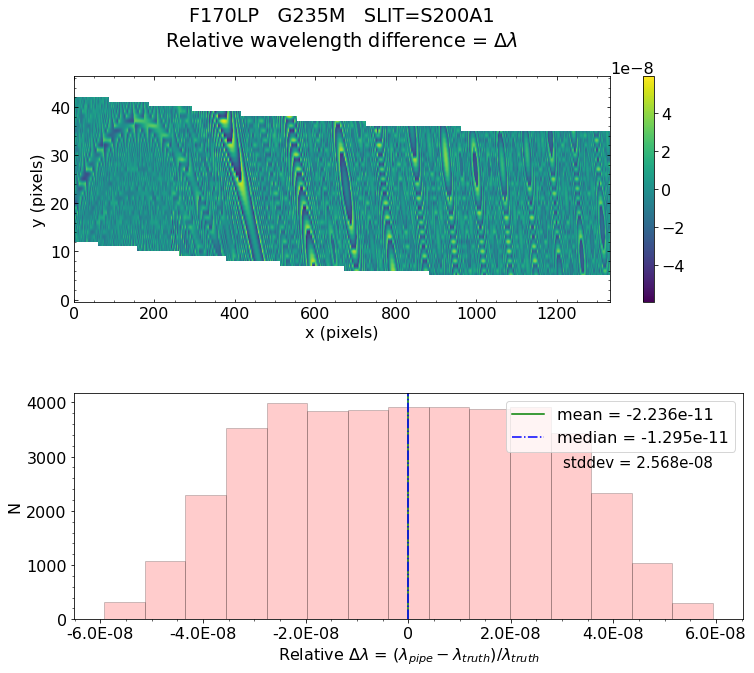

No output_directory was provided. Figures will NOT be saved.


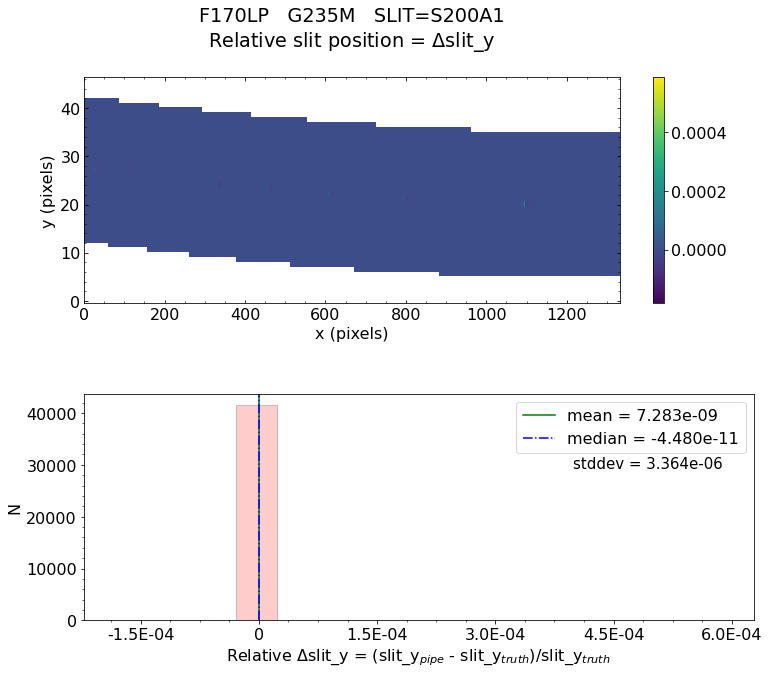

No output_directory was provided. Figures will NOT be saved.


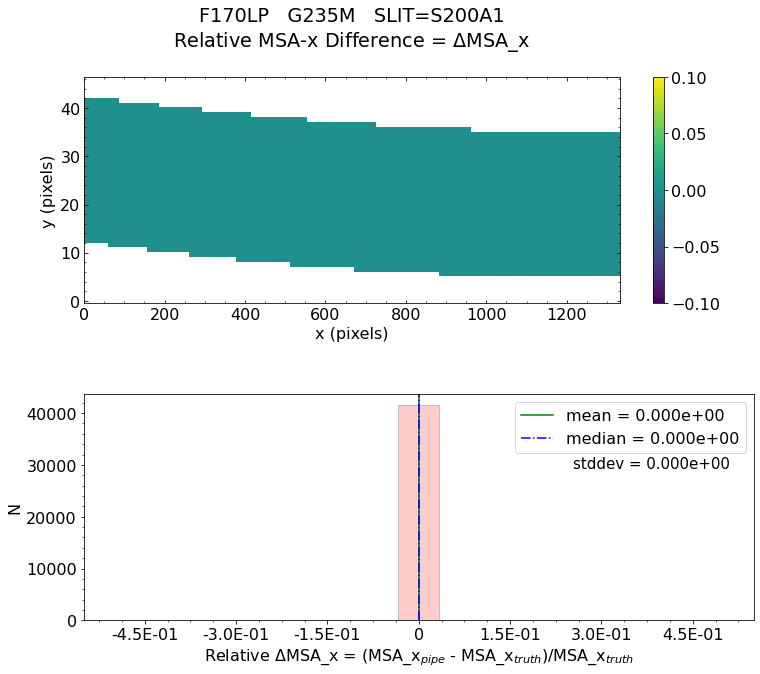

No output_directory was provided. Figures will NOT be saved.


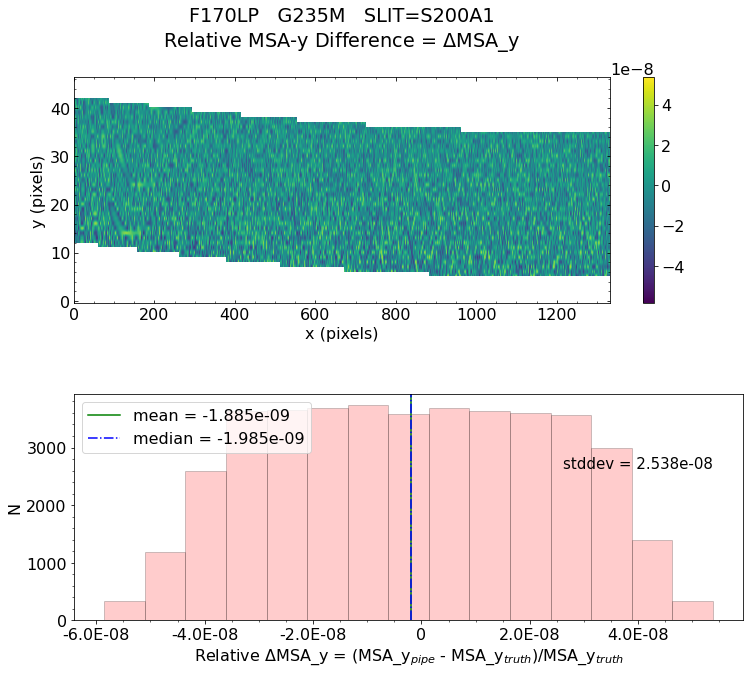

No output_directory was provided. Figures will NOT be saved.


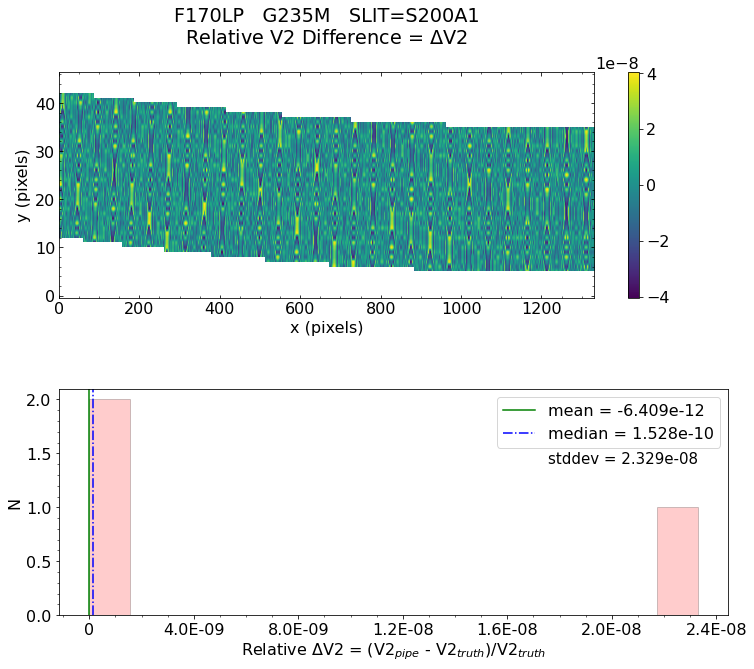

No output_directory was provided. Figures will NOT be saved.


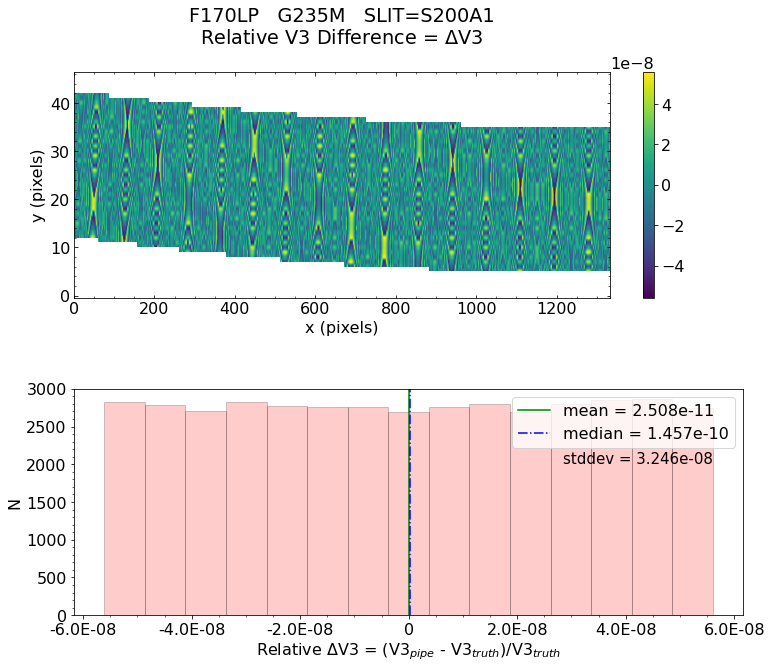


Working with slit: S200A2
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3/ESA_Int_products/Trace_SLIT_A_200_2_V84600004001P0000000002102_39531_JLAB88_000001.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3/ESA_Int_products/Trace_SLIT_A_200_2_V84600004001P0000000002102_39531_JLAB88_000001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     430   ()      
  1  DATA1         1 ImageHDU        22   (1436, 49)   float32   
  2  QUALITY1      1 ImageHDU        24   (1436, 49)   int16 (rescales to uint16)   
  3  VAR1          1 ImageHDU        22   (1436, 49)   float32   
  4  LAMBDA1       1 ImageHDU        23   (1436, 49)   float32   
  5  SLITY1        1 ImageHDU        23   (1436, 49)   float32   
  6  MSAX1         1 ImageHDU        23   (1436, 49)   float32   
  7  MSAY1  

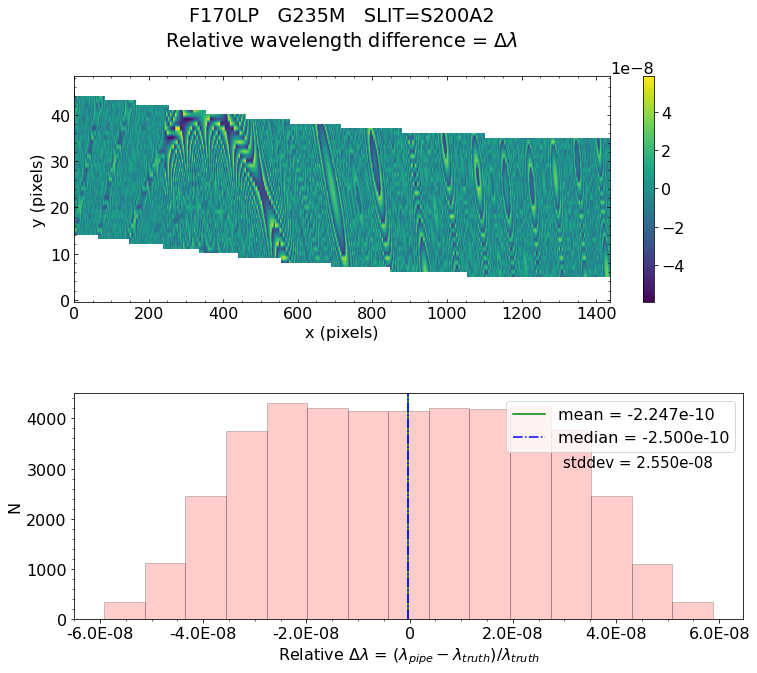

No output_directory was provided. Figures will NOT be saved.


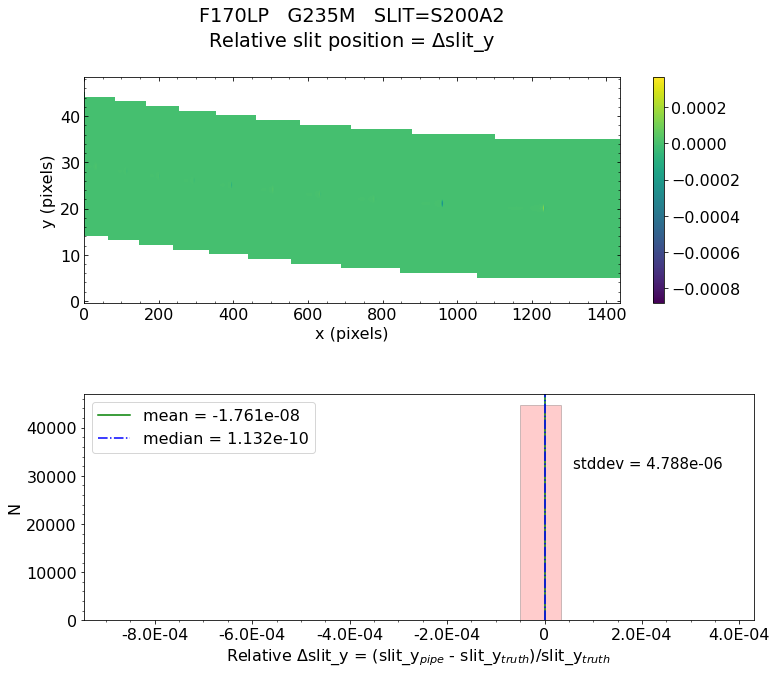

No output_directory was provided. Figures will NOT be saved.


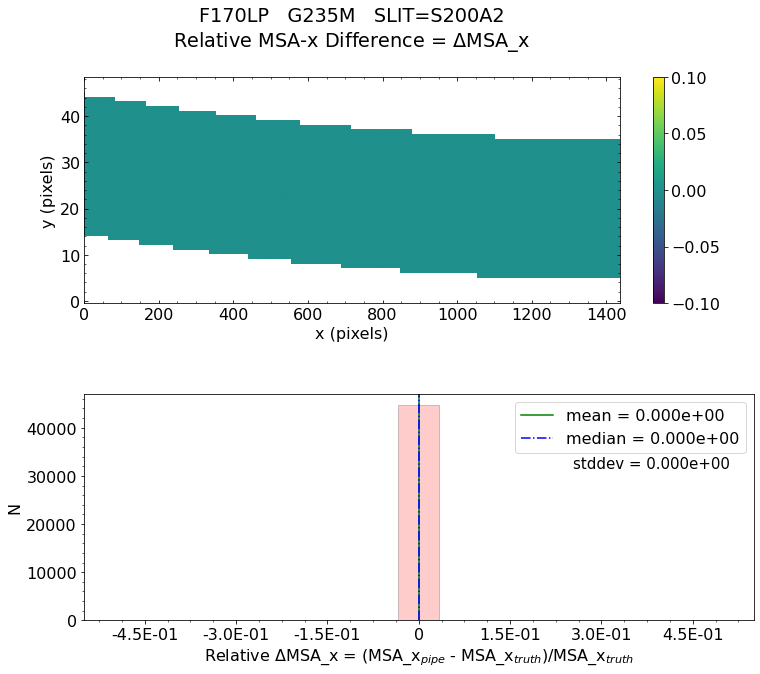

No output_directory was provided. Figures will NOT be saved.


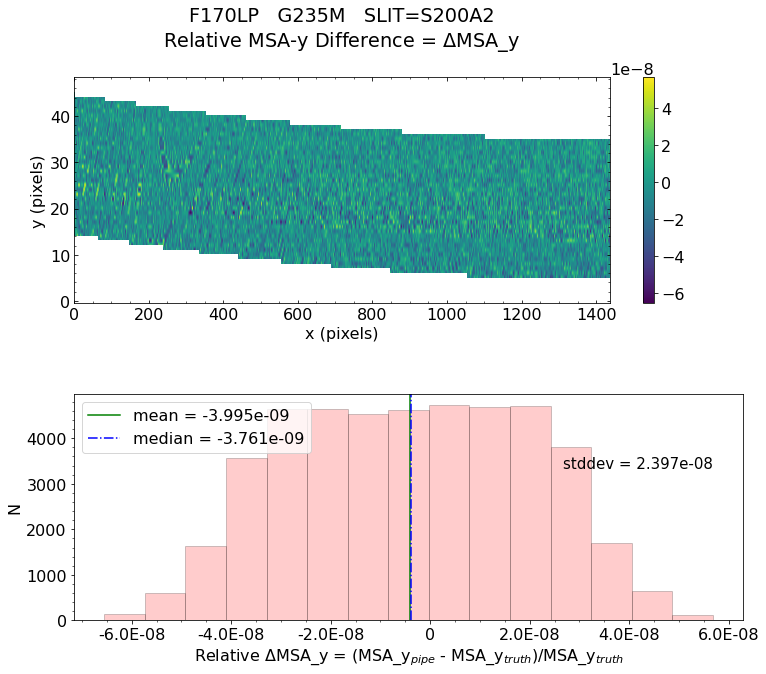

No output_directory was provided. Figures will NOT be saved.


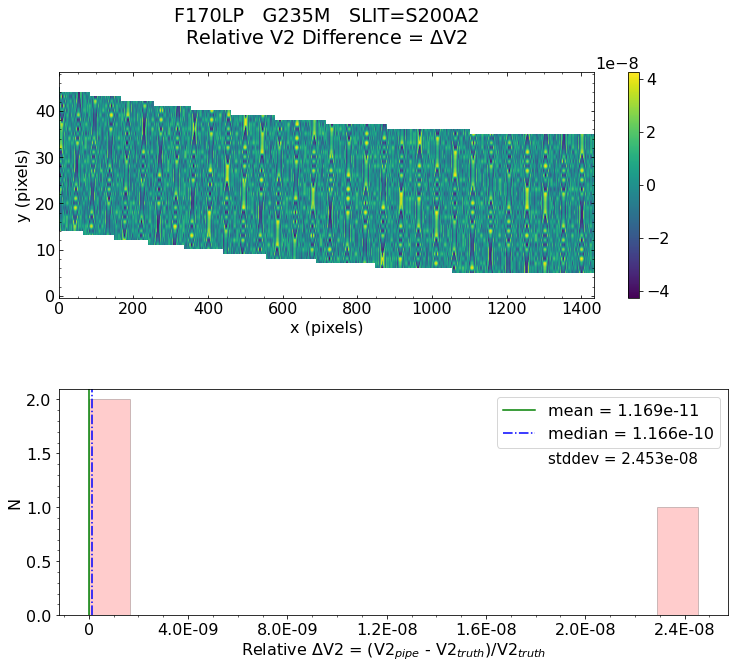

No output_directory was provided. Figures will NOT be saved.


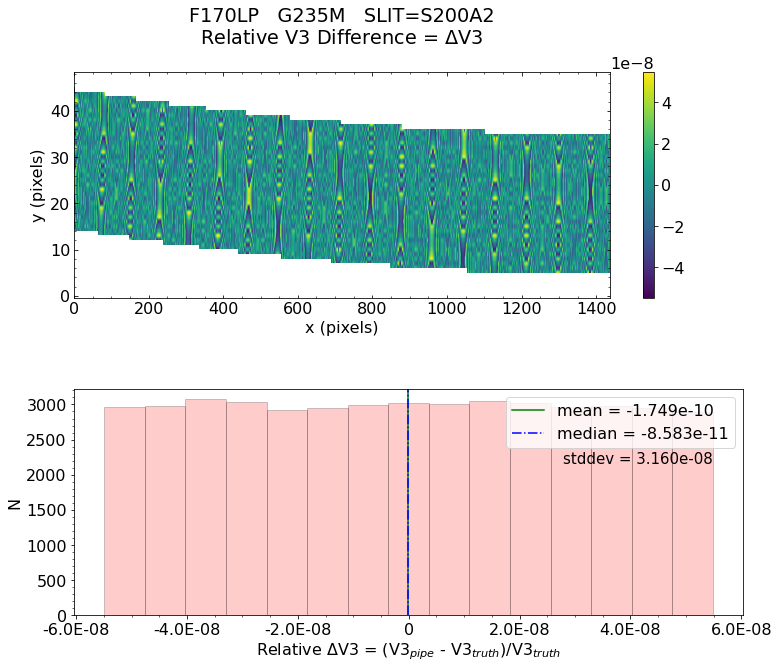


Working with slit: S400A1
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3/ESA_Int_products/Trace_SLIT_A_400_V84600004001P0000000002102_39531_JLAB88_000001.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3/ESA_Int_products/Trace_SLIT_A_400_V84600004001P0000000002102_39531_JLAB88_000001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     430   ()      
  1  DATA1         1 ImageHDU        22   (1401, 52)   float32   
  2  QUALITY1      1 ImageHDU        24   (1401, 52)   int16 (rescales to uint16)   
  3  VAR1          1 ImageHDU        22   (1401, 52)   float32   
  4  LAMBDA1       1 ImageHDU        23   (1401, 52)   float32   
  5  SLITY1        1 ImageHDU        23   (1401, 52)   float32   
  6  MSAX1         1 ImageHDU        23   (1401, 52)   float32   
  7  MSAY1      

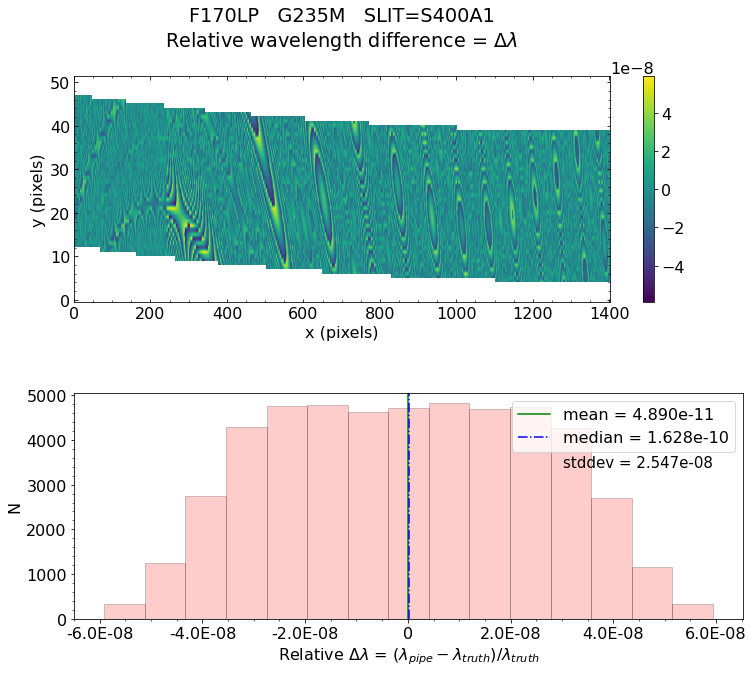

No output_directory was provided. Figures will NOT be saved.


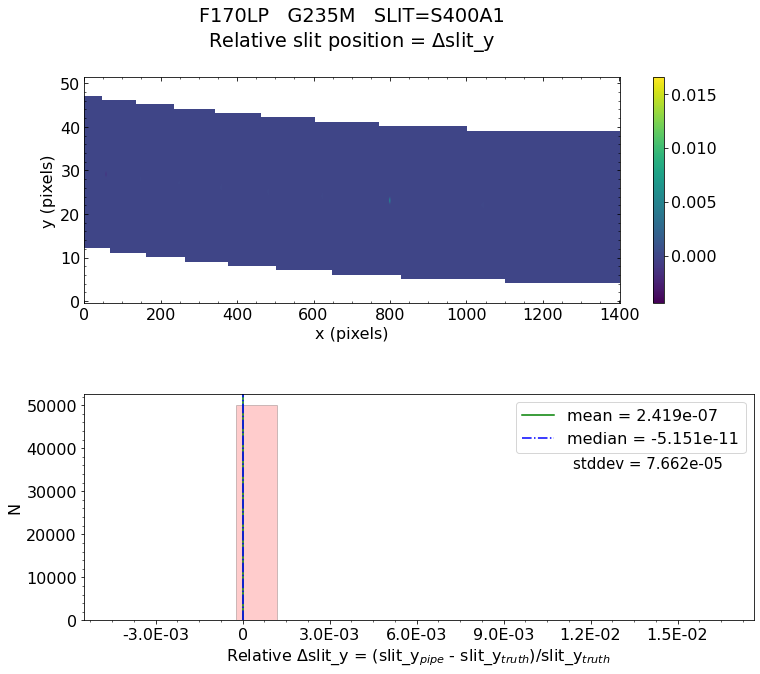

No output_directory was provided. Figures will NOT be saved.


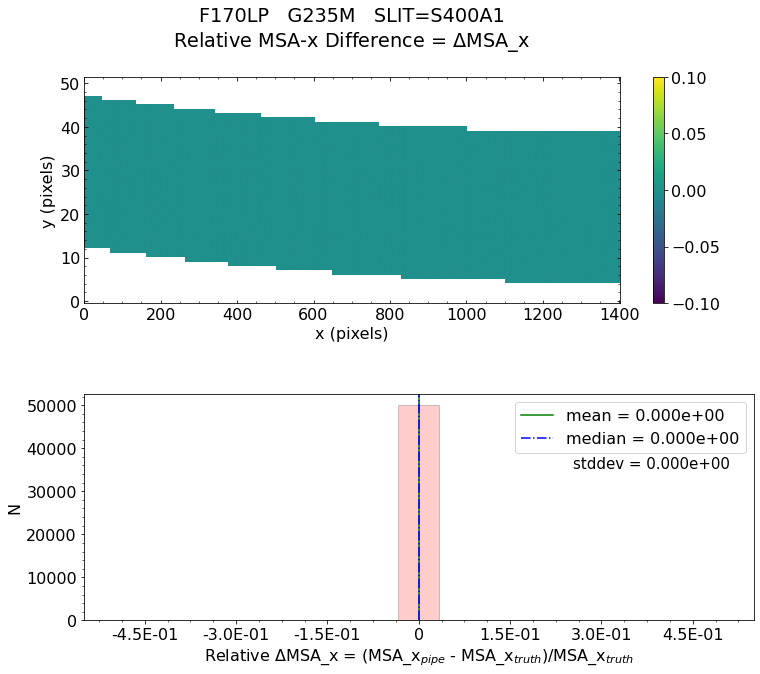

No output_directory was provided. Figures will NOT be saved.


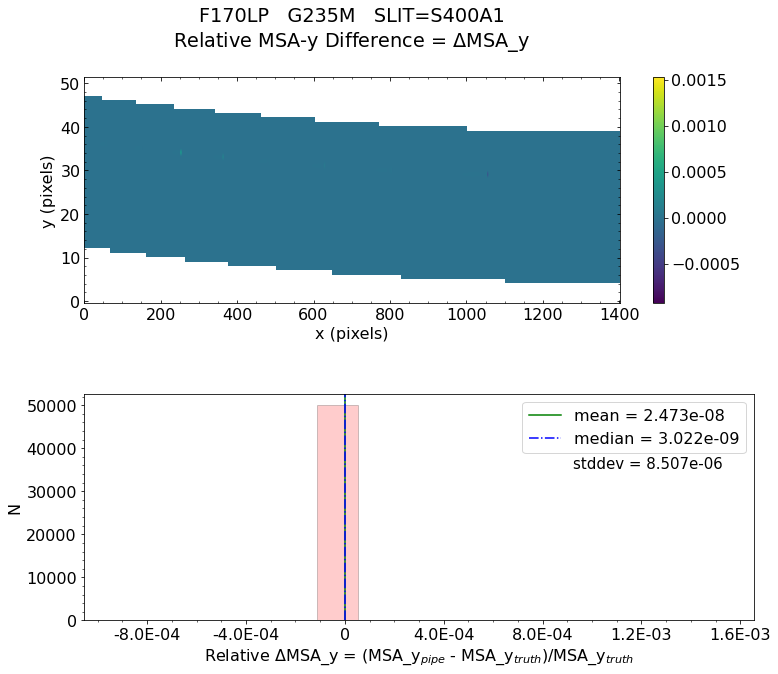

No output_directory was provided. Figures will NOT be saved.


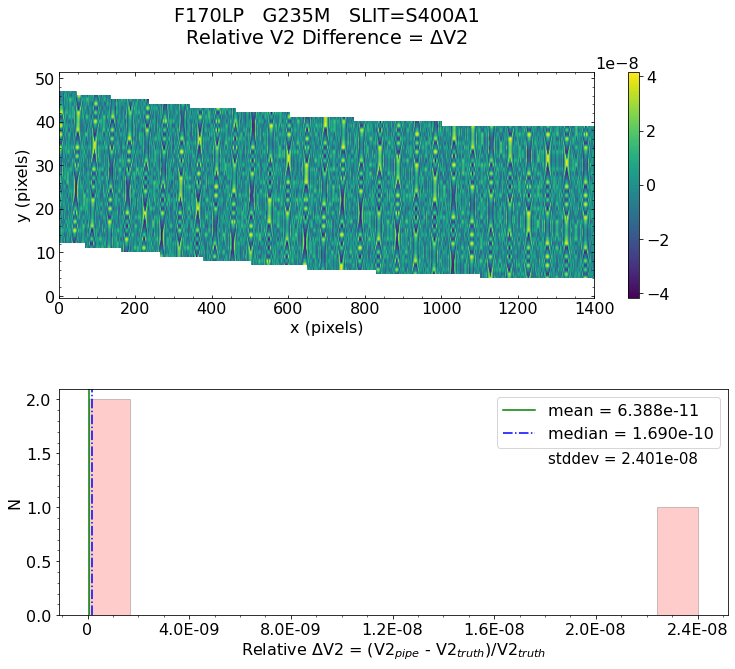

No output_directory was provided. Figures will NOT be saved.


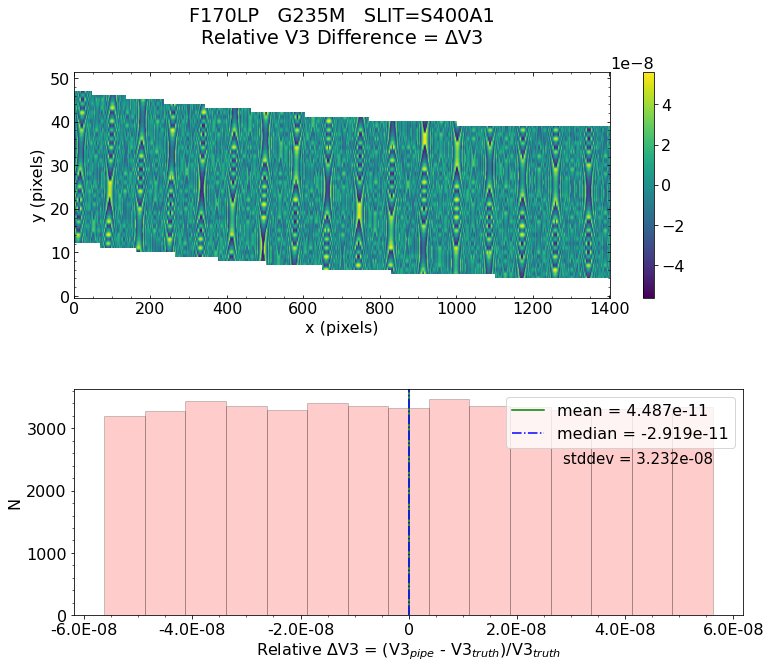


Working with slit: S1600A1
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3/ESA_Int_products/Trace_SLIT_A_1600_V84600004001P0000000002102_39531_JLAB88_000001.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/FS_CV3/ESA_Int_products/Trace_SLIT_A_1600_V84600004001P0000000002102_39531_JLAB88_000001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     430   ()      
  1  DATA1         1 ImageHDU        22   (1378, 29)   float32   
  2  QUALITY1      1 ImageHDU        24   (1378, 29)   int16 (rescales to uint16)   
  3  VAR1          1 ImageHDU        22   (1378, 29)   float32   
  4  LAMBDA1       1 ImageHDU        23   (1378, 29)   float32   
  5  SLITY1        1 ImageHDU        23   (1378, 29)   float32   
  6  MSAX1         1 ImageHDU        23   (1378, 29)   float32   
  7  MSAY1   

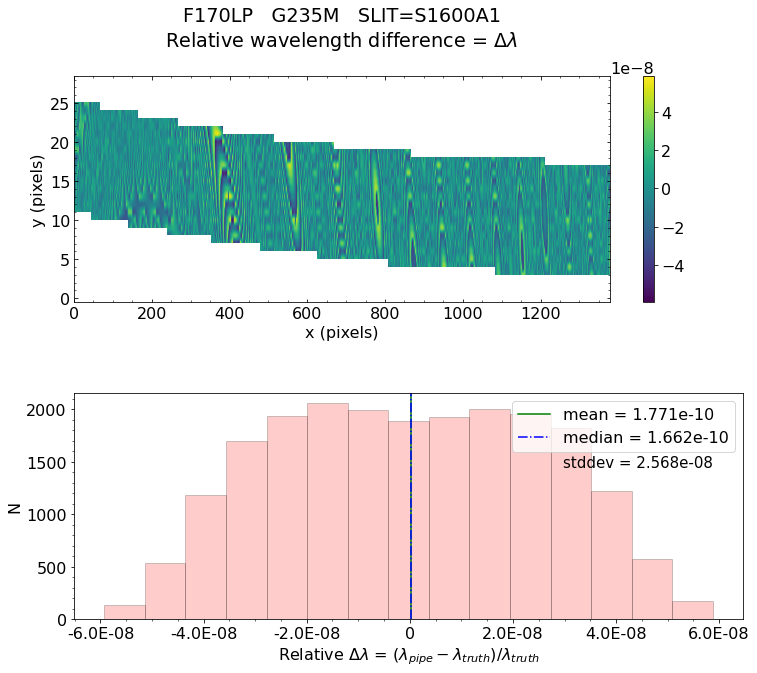

No output_directory was provided. Figures will NOT be saved.


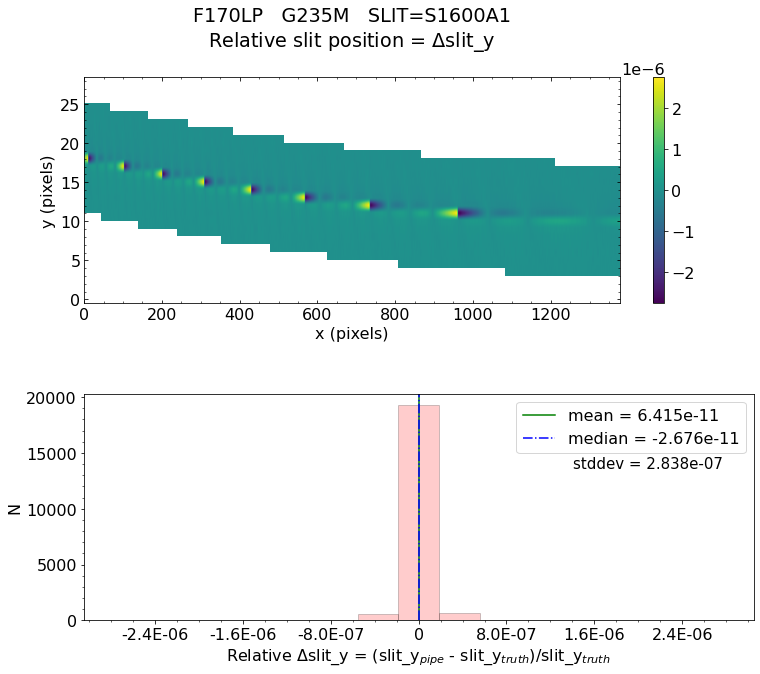

No output_directory was provided. Figures will NOT be saved.


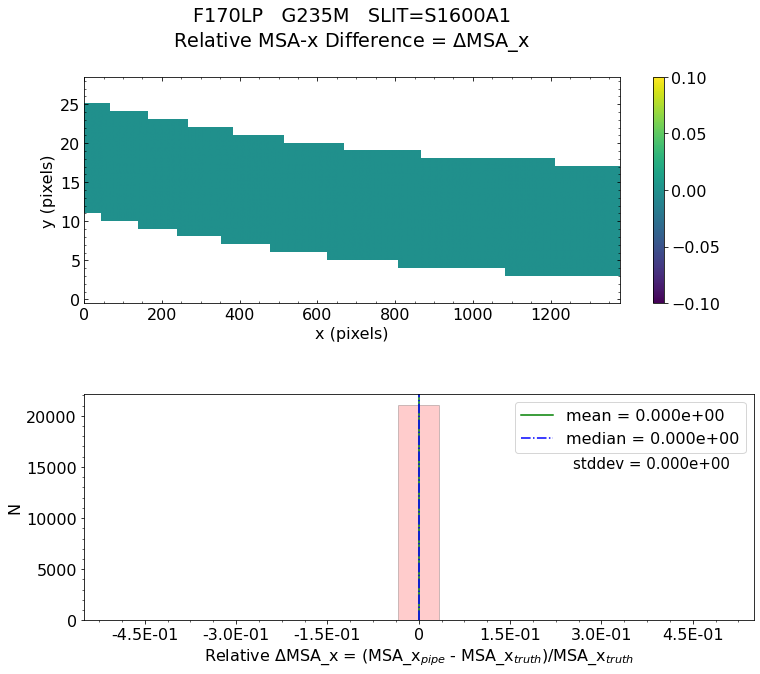

No output_directory was provided. Figures will NOT be saved.


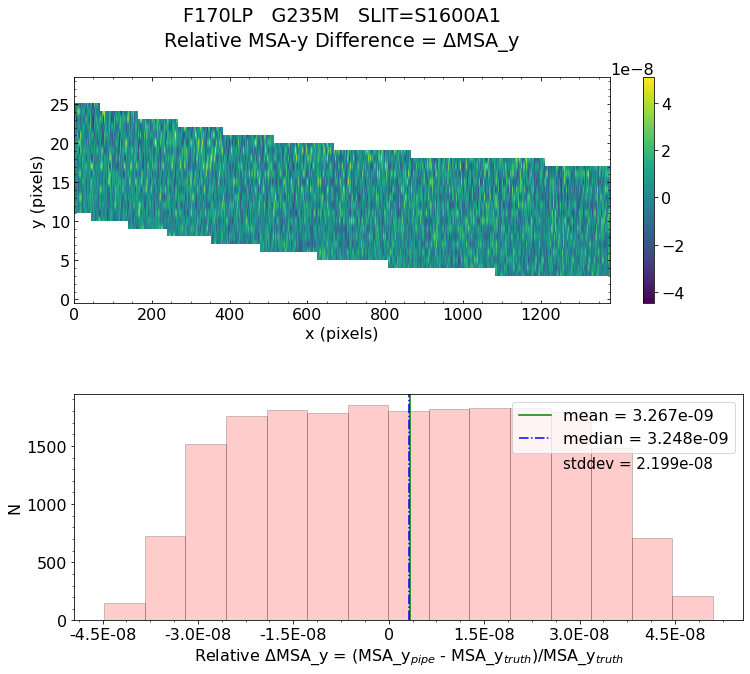

No output_directory was provided. Figures will NOT be saved.


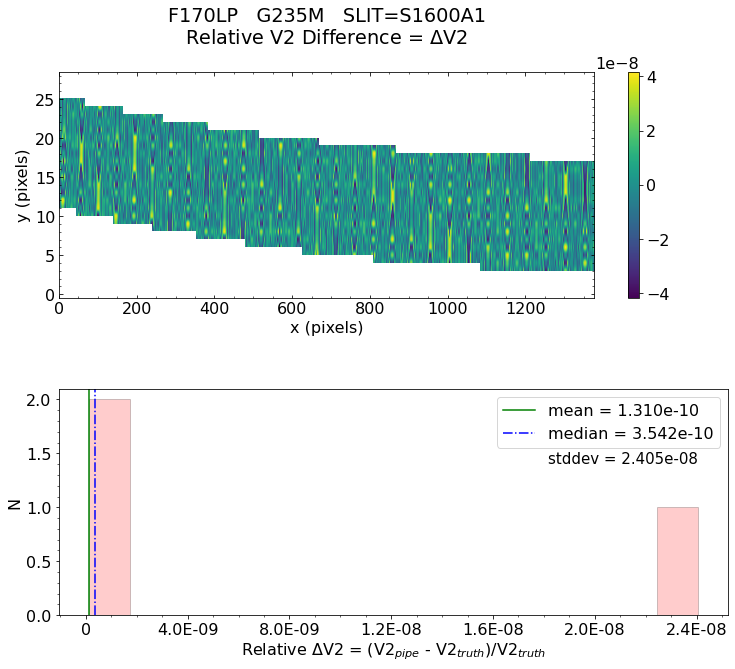

No output_directory was provided. Figures will NOT be saved.


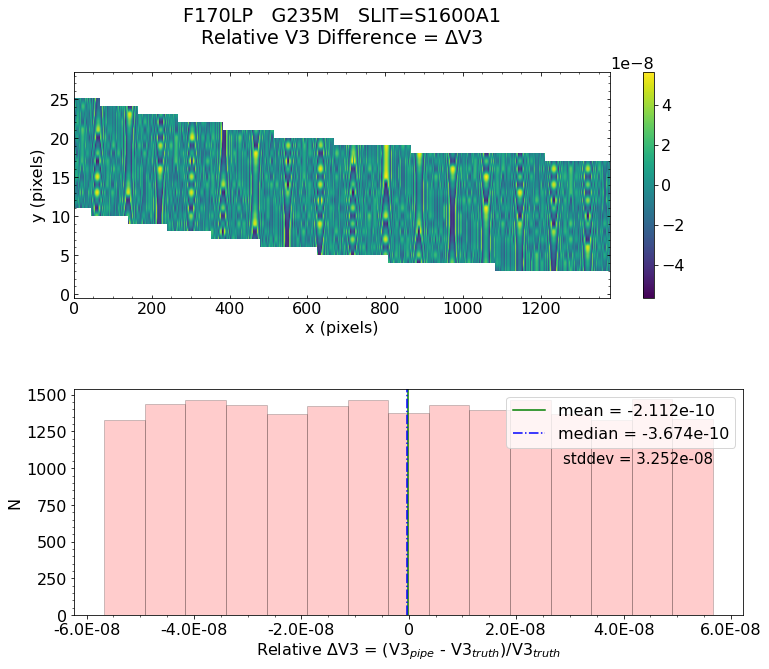


 * The test of V3 difference for slit S200A1 PASSED.

 * The test of V3 difference for slit S200A2 PASSED.

 * The test of V3 difference for slit S400A1 PASSED.

 * The test of V3 difference for slit S1600A1 PASSED.

 *** Final result for assign_wcs test will be reported as PASSED *** 



In [11]:
# Run the validation test
%matplotlib inline
result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_fs.compare_wcs(pipe_result, truth_file=truth_file, 
                                                                                 esa_files_path=esa_files_full_path, 
                                                                                 show_figs=show_figs,
                                                                                 save_figs=save_figs, 
                                                                                 threshold_diff=threshold_diff, 
                                                                                 raw_data_root_file=raw_data_root_file)

In [12]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation test for FS ALLSLITS passed? ", result)


Did assign_wcs validation test for FS ALLSLITS passed?  PASSED


<a id="MOS"></a>
# MOS test

In [13]:
# Set the variables 
data_directory = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/MOS/G140M_LINE1'
input_file = os.path.join(data_directory, 'final_output_caldet1_NRS1.fits')
mode_used = 'MOS'
run_calwebb_spec2 = 'assign_wcs'
msa_conf_name = os.path.join(data_directory,'V8460001000101_new_msa.fits')
save_figs = False
show_figs = True
threshold_diff = 1e-7

In [14]:
# define benchmark (or 'truth') file
compare_assign_wcs_and_extract_2d_with_esa = True

# ESA intermediary products
raw_data_root_file = 'NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits'
esa_files_path = "/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/"
esa_files_full_path = "".join([esa_files_path, mode_used, "_CV3/ESA_Int_products"])

# pipeline intermediary products
truth_file = os.path.join(data_directory, 'final_output_caldet1_NRS1_assign_wcs_truth.fits')

if not compare_assign_wcs_and_extract_2d_with_esa:
    esa_files_path, raw_data_root_file = None, None
else:
    truth_file = None
    

In [15]:
# Run the pipeline step
step_output_file = input_file.replace(".fits", "_assign_wcs.fits")
pipe_result = AssignWcsStep.call(input_file)
#pipe_result.save(step_output_file)   # this is to save the pipeline output to a file

2020-07-09 16:05:35,130 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-07-09 16:05:35,131 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-07-09 16:05:35,224 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/MOS/G140M_LINE1/final_output_caldet1_NRS1.fits',).
2020-07-09 16:05:35,226 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-07-09 16:05:35,475 - stpipe.AssignWcsStep - INFO - Retrieving open slitlets for msa_metadata_id = 1 and dither_index = 1
2020-07-09 16:05:35,770 - stpipe.Assig

2020-07-09 16:05:37,460 - stpipe.AssignWcsStep - INFO - Computing WCS for 27 open slitlets
2020-07-09 16:05:37,485 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg
2020-07-09 16:05:37,485 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg
2020-07-09 16:05:37,486 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg
2020-07-09 16:05:37,487 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2020-07-09 16:05:37,509 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]
2020-07-09 16:05:37,919 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 1
2020-07-09 16:05:37,947 - stpipe.AssignWcsStep - INFO - There are 11 open slits in quadrant 2
2020-07-09 16:05:38,075 - stpipe.AssignWcsStep - INFO - There are 4 open slits in quadrant 3
2020-07-09 16:05:38,220 - stpipe.AssignWcsStep - INFO - There are 10 open slits in quadrant 4
2020-07-09 16:05:38,344 - stpipe.AssignWcsStep - INFO - There are 0 o

Comparing to ESA data
from assign_wcs file  -->     Detector: NRS1   Grating: G140M   Filter: F100LP   Lamp: LINE1
GWA_XTILT: 0.3316612243652344
GWA_YTILT: 0.1260581910610199
GWA_TTILT: 40.19677228555539
Using this MSA shutter configuration file: /Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/MOS/G140M_LINE1/V8460001000101_new_msa.fits

Working with slit: 53
Pipeline shutter info:   quadrant= 1   row= 330   col=144
Using this raw data file to find the corresponding ESA file: NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits
 * File name matches raw file used for create_data.
0
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/MOS_CV3/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_MOS/Trace_MOS_1_330_144_V84600010001P0000000002101_39547_JLAB88.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_s

2020-07-09 16:05:41,239 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/auxiliary_functions.py:567: RuntimeWarning: invalid value encountered in less
  in_slit = np.logical_and(edy < .5,  edy > -.5)

2020-07-09 16:05:41,240 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/auxiliary_functions.py:567: RuntimeWarning: invalid value encountered in greater
  in_slit = np.logical_and(edy < .5,  edy > -.5)




   Relative Wavelength Difference  :   mean = 1.325e-10    median = 4.840e-10    stdev = 2.946e-08
    Maximum   RelativeWavelength Difference = 5.848e-08
    Minimum   RelativeWavelength Difference = -5.771e-08
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
Result for test of Wavelength Difference: PASSED

   Relative Slit-Y Difference  :   mean = -2.456e-07    median = 6.129e-09    stdev = 1.346e-05
    Maximum   RelativeSlit-Y Difference = 5.688e-05
    Minimum   RelativeSlit-Y Difference = -6.161e-04
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 59%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 12%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


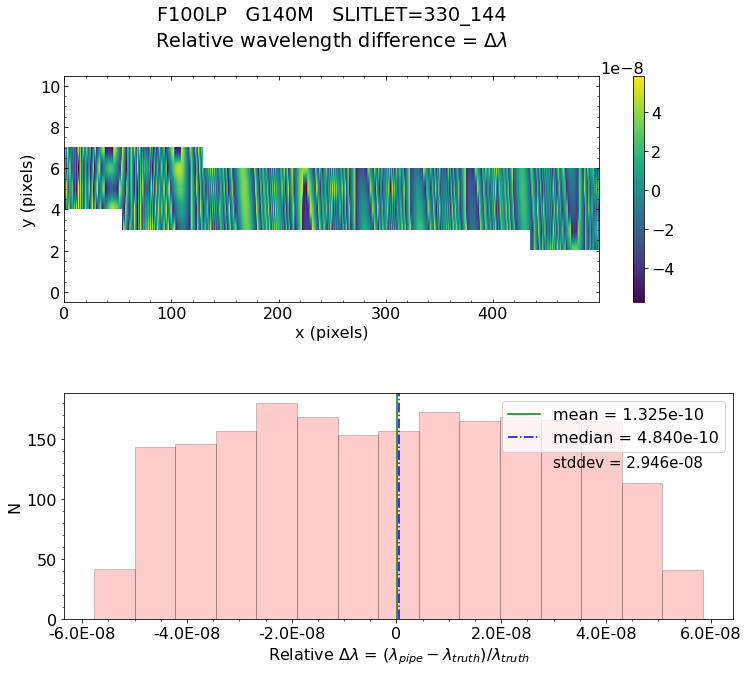

No output_directory was provided. Figures will NOT be saved.


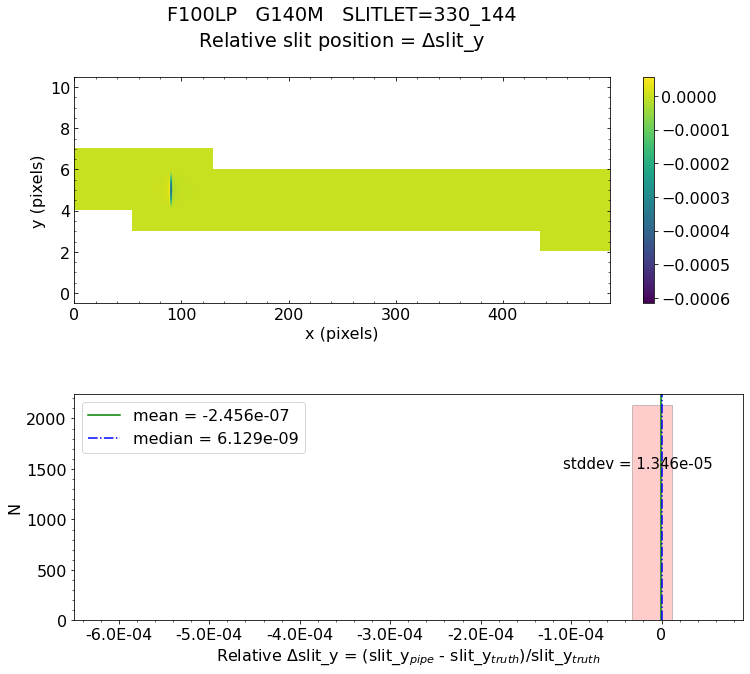

No output_directory was provided. Figures will NOT be saved.


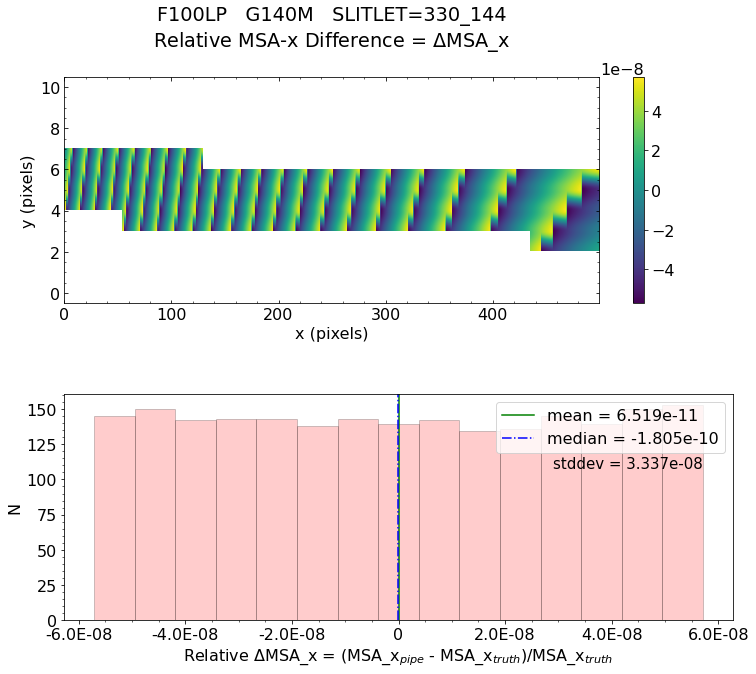

No output_directory was provided. Figures will NOT be saved.


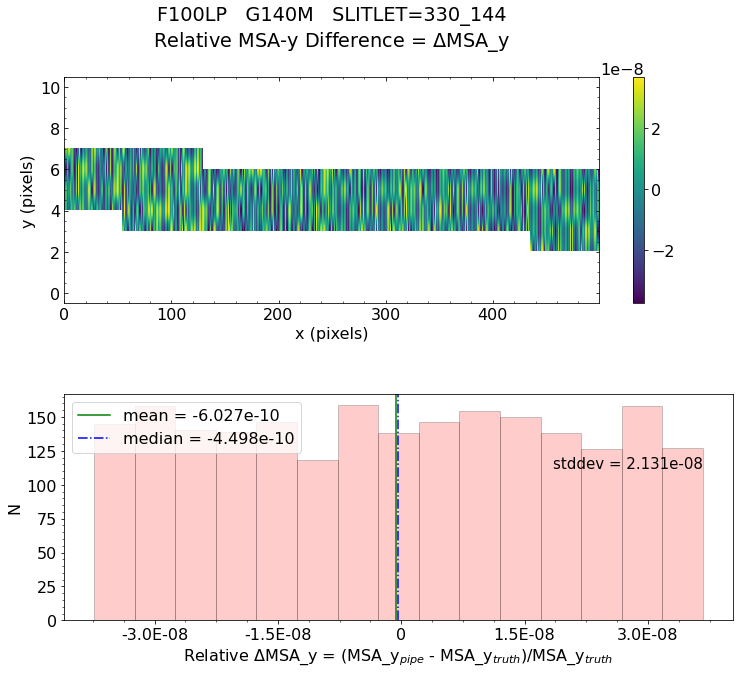


Working with slit: 54
Pipeline shutter info:   quadrant= 1   row= 330   col=146
Using this raw data file to find the corresponding ESA file: NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits
 * File name matches raw file used for create_data.
0
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/MOS_CV3/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_MOS/Trace_MOS_1_330_146_V84600010001P0000000002101_39547_JLAB88.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/MOS_CV3/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_MOS/Trace_MOS_1_330_146_V84600010001P0000000002101_39547_JLAB88.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     434   ()      
  1  DATA1         1 Ima

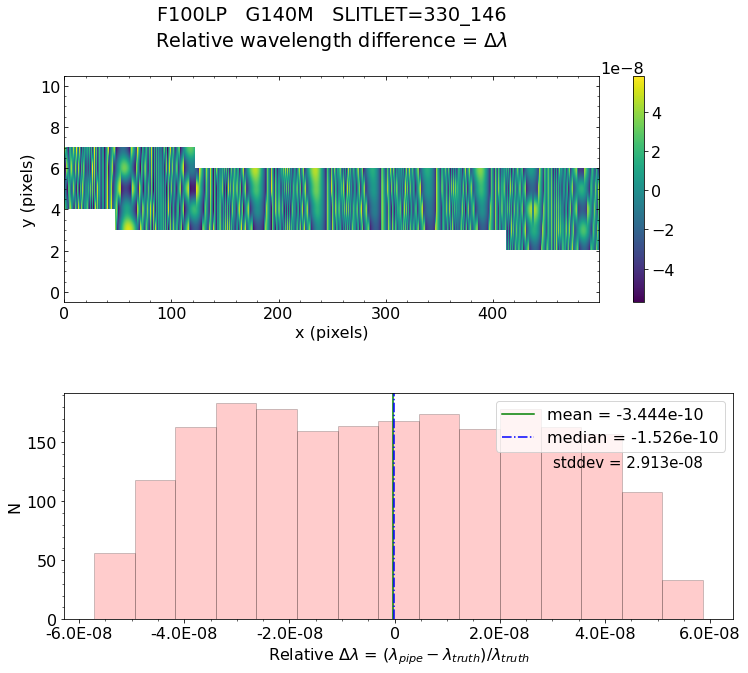

No output_directory was provided. Figures will NOT be saved.


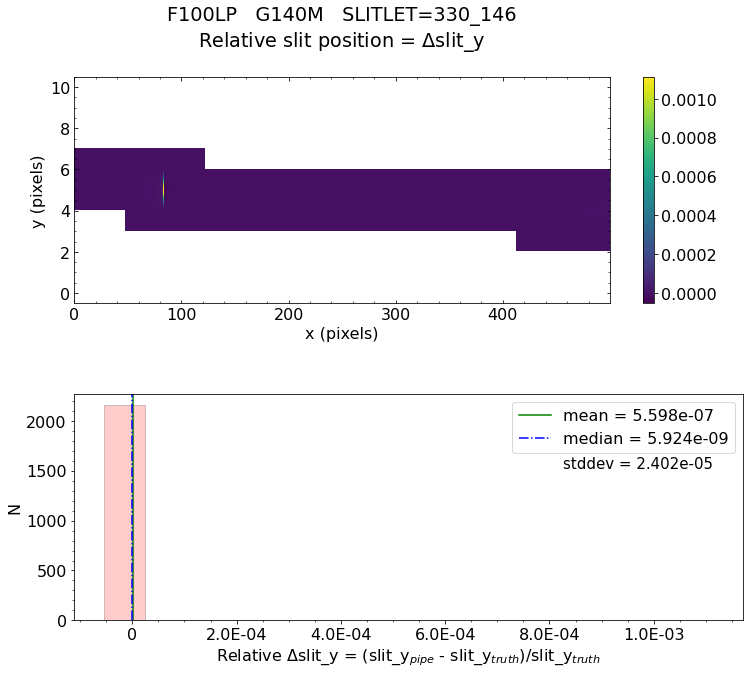

No output_directory was provided. Figures will NOT be saved.


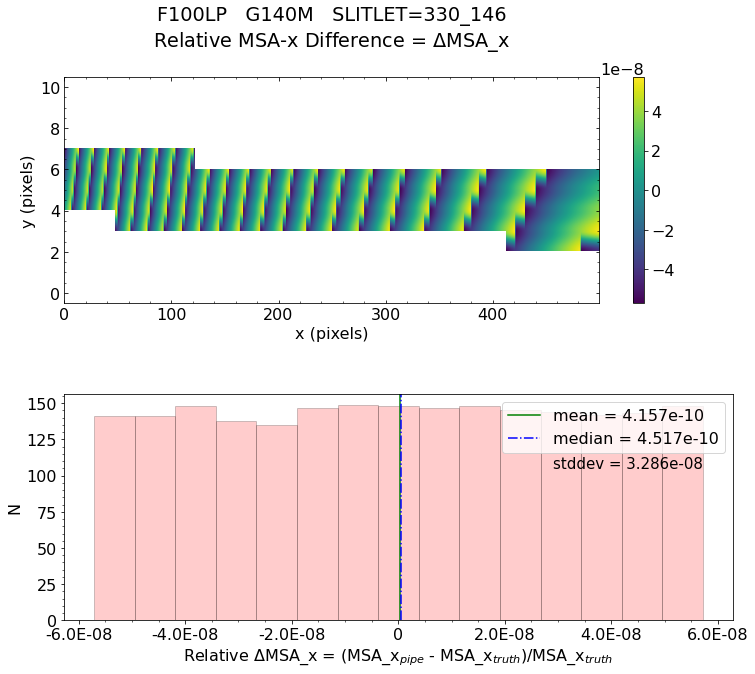

No output_directory was provided. Figures will NOT be saved.


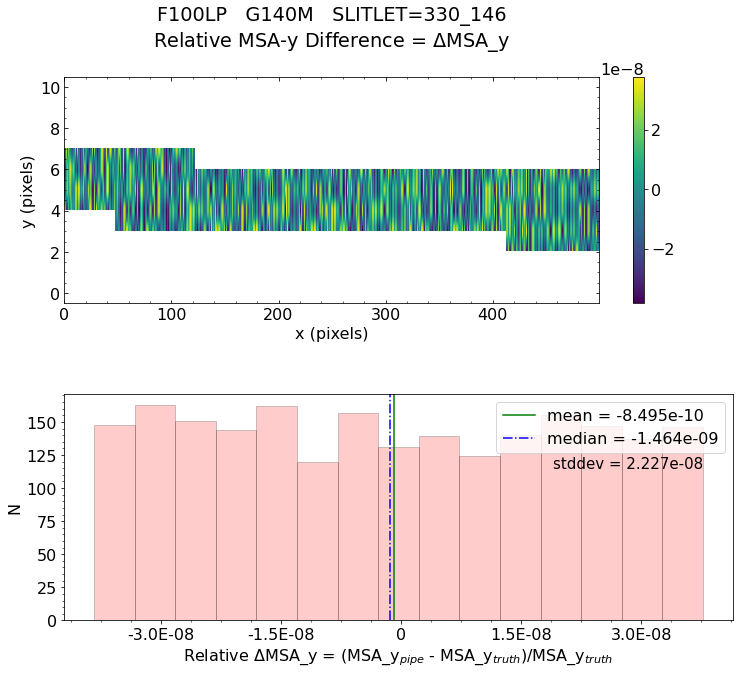


Working with slit: 42
Pipeline shutter info:   quadrant= 2   row= 138   col=56
Using this raw data file to find the corresponding ESA file: NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits
 * File name matches raw file used for create_data.
0
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/MOS_CV3/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_MOS/Trace_MOS_2_138_056_V84600010001P0000000002101_39547_JLAB88.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/MOS_CV3/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_MOS/Trace_MOS_2_138_056_V84600010001P0000000002101_39547_JLAB88.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     434   ()      
  1  DATA1         1 Imag

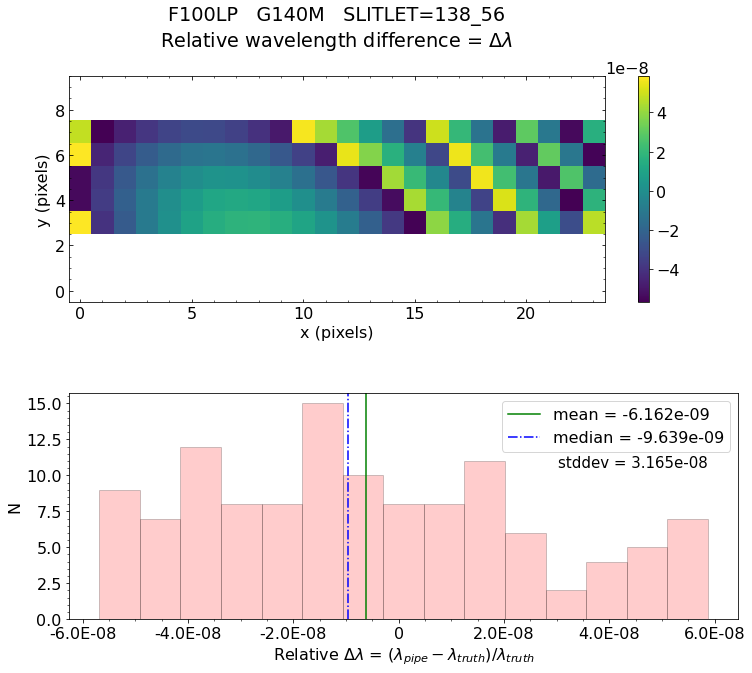

No output_directory was provided. Figures will NOT be saved.


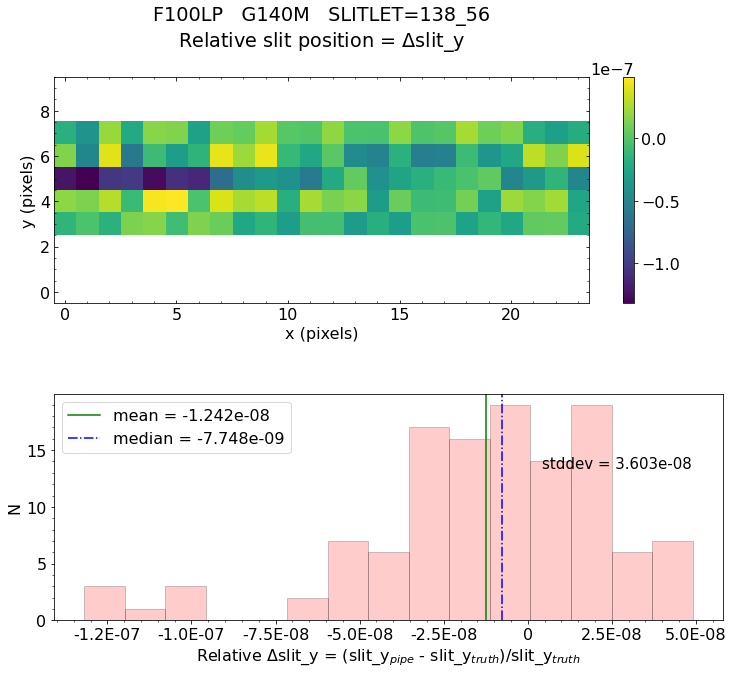

No output_directory was provided. Figures will NOT be saved.


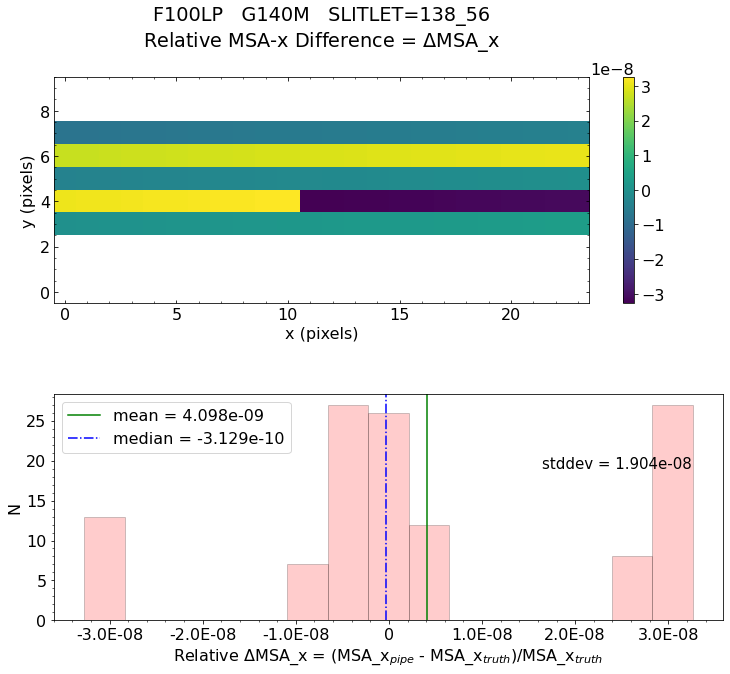

No output_directory was provided. Figures will NOT be saved.


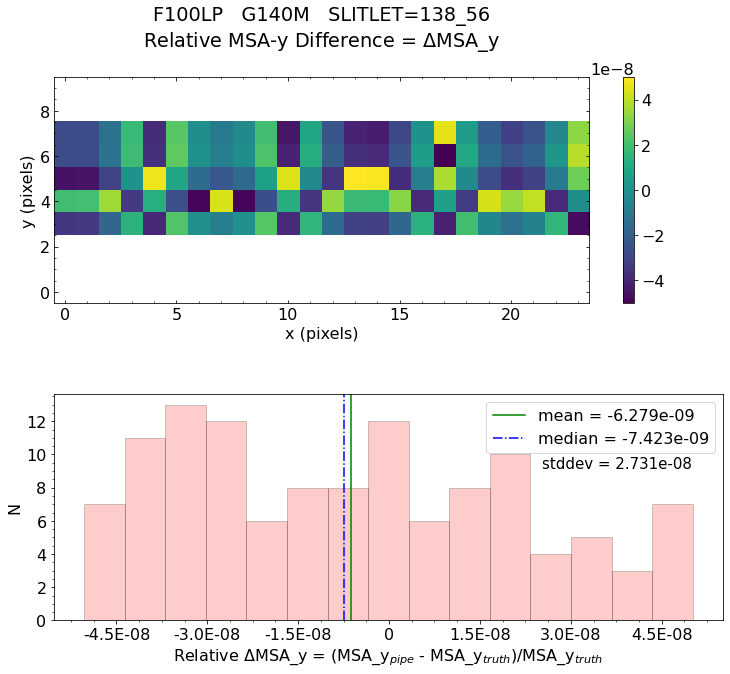


Working with slit: 43
Pipeline shutter info:   quadrant= 2   row= 155   col=82
Using this raw data file to find the corresponding ESA file: NRSV84600010001P0000000002101_4_491_SE_2016-01-17T17h34m08.fits
 * File name matches raw file used for create_data.
0
Using this ESA file: 
/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/MOS_CV3/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_MOS/Trace_MOS_2_155_082_V84600010001P0000000002101_39547_JLAB88.fits
* ESA file contents 
Filename: /grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/MOS_CV3/ESA_Int_products/V84600010001P0000000002101_39547_JLAB88/V84600010001P0000000002101_39547_JLAB88_trace_MOS/Trace_MOS_2_155_082_V84600010001P0000000002101_39547_JLAB88.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     434   ()      
  1  DATA1         1 Imag

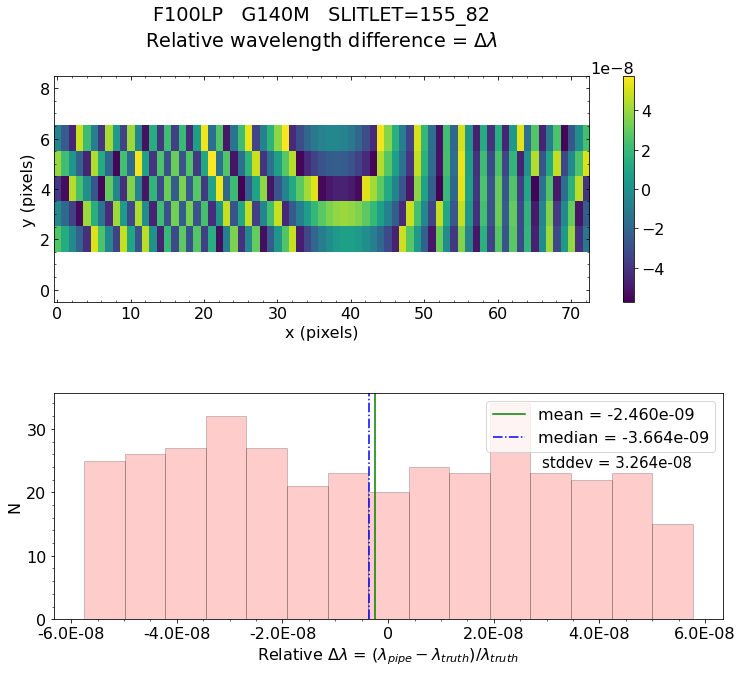

No output_directory was provided. Figures will NOT be saved.


In [ ]:
# Run the validation test
%matplotlib inline
result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_mos.compare_wcs(pipe_result, 
                                                                                  msa_conf_name=msa_conf_name, 
                                                                                  truth_file=truth_file,
                                                                                  esa_files_path=esa_files_full_path, 
                                                                                  show_figs=show_figs, 
                                                                                  save_figs=save_figs, 
                                                                                  threshold_diff=threshold_diff,
                                                                                  mode_used=mode_used, 
                                                                                  raw_data_root_file=raw_data_root_file)

In [ ]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation for MOS test passed? ", result)


<a id="IFU"></a>
# IFU test

In [ ]:
# Set the variables 
data_directory = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/IFU_CV3/G395H_OPAQUE'
input_file = os.path.join(data_directory, 'final_output_caldet1_NRS2.fits')
mode_used = 'IFU'
run_calwebb_spec2 = 'assign_wcs'
save_figs = False
show_figs = True
threshold_diff = 1e-7

In [ ]:
# define benchmark (or 'truth') file
compare_assign_wcs_and_extract_2d_with_esa = True

# ESA intermediary products
raw_data_root_file = 'NRSSMOS-MOD-G3H-18-5344134506_1_492_SE_2015-12-10T13h57m30.fits'
esa_files_path = "/grp/jwst/wit4/nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite/"
esa_files_full_path = "".join([esa_files_path, mode_used, "_CV3/ESA_Int_products"])

# pipeline intermediary products
truth_file = os.path.join(data_directory, 'final_output_caldet1_NRS2_assign_wcs_truth.fits')

if not compare_assign_wcs_and_extract_2d_with_esa:
    esa_files_path, raw_data_root_file = None, None
else:
    truth_file = None
    

In [ ]:
# Run the pipeline step
step_output_file = input_file.replace(".fits", "_assign_wcs.fits")
pipe_result = AssignWcsStep.call(input_file)
#pipe_result.save(step_output_file)   # this is to save the pipeline output to a file

In [ ]:
# Run the validation test
%matplotlib inline
result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_ifu.compare_wcs(pipe_result, truth_file=truth_file, 
                                                                                  esa_files_path=esa_files_full_path, 
                                                                                  show_figs=show_figs,
                                                                                  save_figs=save_figs, 
                                                                                  threshold_diff=threshold_diff, 
                                                                                  raw_data_root_file=raw_data_root_file)

In [ ]:
# Quickly see if the test passed 
   
print("Did assign_wcs validation test for IFU passed? ", result)


<a id="results"></a>
## Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.

<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** 04/09/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 